# Patch volume
Simple detection of path volume, which Tim delineated in CTAN

In [1]:
import platform
import os
import glob
import pandas
import numpy
import imageio
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import seaborn
import dask
import dask_image.imread
from dask.distributed import Client
from numcodecs import Blosc
from tqdm import notebook

In [2]:
# Set dask temporary folder
# Do this before creating a client: https://stackoverflow.com/a/62804525/323100
if 'Linux' in platform.system():
    tmp = os.path.join(os.sep, 'media', 'habi', 'Fast_SSD')
elif 'Darwin' in platform.system():
    import tempfile
    tmp = tempfile.gettempdir()
else:
    if 'anaklin' in platform.node():
        tmp = os.path.join('F:\\')
    else:
        tmp = os.path.join('D:\\')
dask.config.set({'temporary_directory': os.path.join(tmp, 'tmp')})

In [3]:
# Start dask client and tell where we can see what it does
client = Client()
print('You can seee what DASK is doing at "http://localhost:%s/status"' % client.scheduler_info()['services']['dashboard'])

You can seee what DASK is doing at "http://localhost:8787/status"


In [4]:
# Ignore warnings in the notebook
#import warnings
#warnings.filterwarnings("ignore")

In [5]:
# Set up figure defaults
plt.rc('image', cmap='gray', interpolation='nearest')  # Display all images in b&w and with 'nearest' interpolation
plt.rcParams['figure.figsize'] = (16, 9)  # Size up figures a bit
plt.rcParams['figure.dpi'] = 200  # Increase dpi

In [6]:
# Setup scale bar defaults
plt.rcParams['scalebar.location'] = 'lower right'
plt.rcParams['scalebar.frameon'] = False
plt.rcParams['scalebar.color'] = 'white'

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The validate_legend_loc function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  


In [7]:
# Display all plots identically
lines = 3
# And then do something like
# plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)

In [111]:
def get_git_hash():
    """
    Get the current git hash from the repository.
    Based on http://stackoverflow.com/a/949391/323100 and
    http://stackoverflow.com/a/18283905/323100
    """
    from subprocess import Popen, PIPE
    import os
    gitprocess = Popen(['git', '--git-dir', os.path.join(os.getcwd(), '.git'),
                        'rev-parse', '--short', '--verify', 'HEAD'],
                       stdout=PIPE)
    (output, _) = gitprocess.communicate()
    return output.strip().decode("utf-8")

In [112]:
# What are we working with?
the_current_git_hash = get_git_hash()
print('We are working with version %s of the analyis notebook.'
      % the_current_git_hash)

We are working with version d714f10 of the analyis notebook.


In [113]:
# Generate the output folder
# Including the git hash, so we (potentially) have different versions of all the images we generate
OutputDir = os.path.join('Output', the_current_git_hash)
os.makedirs(OutputDir, exist_ok=True)

In [114]:
# Different locations if running either on Linux or Windows
if 'anaklin25' in platform.node():
    FastSSD = True
else:
    FastSSD = False
# to speed things up significantly
if 'Linux' in platform.system():
    if FastSSD:
        BasePath = os.path.join(os.sep, 'media', 'habi', 'Fast_SSD')
    else:
        BasePath = os.path.join(os.sep, 'home', 'habi', '1272')
elif 'Darwin' in platform.system():
    BasePath = os.path.join('/Volumes/2TBSSD/')
else:
    if FastSSD:
        BasePath = os.path.join('F:\\')
    else:
        if 'anaklin' in platform.node():
            BasePath = os.path.join('S:\\')
        else:
            BasePath = os.path.join('D:\\Results')
Root = os.path.join(BasePath, 'Hearts Melly')
print('We are loading all the data from %s' % Root)

We are loading all the data from F:\Hearts Melly


In [115]:
def get_pixelsize(logfile):
    """Get the pixel size from the scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Image Pixel' in line and 'Scaled' not in line:
                pixelsize = float(line.split('=')[1])
    return(pixelsize)

In [116]:
# Make us a dataframe for saving all that we need
Data = pandas.DataFrame()

In [117]:
# Get *all* log files
Data['LogFile'] = [f for f in sorted(glob.glob(os.path.join(Root, '**', '*rec.log'), recursive=True))]

In [118]:
# Get all folders
Data['Folder'] = [os.path.dirname(f) for f in Data['LogFile']]

In [119]:
# Get rid of all non-rec logfiles
for c, row in Data.iterrows():
    if 'rec' not in row.Folder:
        Data.drop([c], inplace=True)
    if 'tweak' in row.Folder:
        Data.drop([c], inplace=True)        
# Reset dataframe to something that we would get if we only would have loaded the 'rec' files
Data = Data.reset_index(drop=True)

In [120]:
# Drop all folders we don't need
for c, row in Data.iterrows():
    if 'Rat' not in row.Folder:
        Data.drop([c], inplace=True)
    elif 'Rat4' in row.Folder:
        Data.drop([c], inplace=True)
    elif 'Rat5' in row.Folder:
        Data.drop([c], inplace=True)
    elif 'Test' in row.Folder:
        Data.drop([c], inplace=True)        
# Reset dataframe to something that we would get if we only would have loaded the 'rec' files
Data = Data.reset_index(drop=True)

In [121]:
Data.head()

,LogFile,Folder
0,F:\Hearts Melly\Rat60\cu_10um\rec\Rat60_rec.log,F:\Hearts Melly\Rat60\cu_10um\rec
1,F:\Hearts Melly\Rat60\overview\rec\Rat60_rec.log,F:\Hearts Melly\Rat60\overview\rec
2,F:\Hearts Melly\Rat61\cu_10um\rec\Rat61_rec.log,F:\Hearts Melly\Rat61\cu_10um\rec
3,F:\Hearts Melly\Rat61\overview\rec\Rat61_rec.log,F:\Hearts Melly\Rat61\overview\rec
4,F:\Hearts Melly\Rat62\cu_10um\rec\Rat62_rec.log,F:\Hearts Melly\Rat62\cu_10um\rec


In [122]:
# Get some data from folders
Data['Sample'] = [l[len(Root)+1:].split(os.sep)[0] for l in Data['LogFile']]
Data['Animal'] = [r.replace('Rat', '') for r in Data['Sample']]
Data['Scan'] = [l[len(Root)+1:].split(os.sep)[1] for l in Data['LogFile']]

In [123]:
# Read in animals list from Ludovic
AnimalTable = pandas.read_excel('Animals.xlsx',
                                engine='openpyxl',
                                header=None,
                                names=['Animal', 'Gender', '', 'Experiment', 'Timepoint'])

In [124]:
AnimalTable.sample(n=5)

,Animal,Gender,,Experiment,Timepoint
10,70,M,EPI,tachosil only,28
17,84,M,EPI,V,28
3,63,F,EPI,F,7
0,60,F,EPI,V+P,7
6,66,M,EPI,V+P,28


In [125]:
Data.sample(n=5)

,LogFile,Folder,Sample,Animal,Scan
31,F:\Hearts Melly\Rat82\cu_10um\rec\Rat82_rec.log,F:\Hearts Melly\Rat82\cu_10um\rec,Rat82,82,cu_10um
20,F:\Hearts Melly\Rat71\overview\rec\Rat71_rec.log,F:\Hearts Melly\Rat71\overview\rec,Rat71,71,overview
0,F:\Hearts Melly\Rat60\cu_10um\rec\Rat60_rec.log,F:\Hearts Melly\Rat60\cu_10um\rec,Rat60,60,cu_10um
18,F:\Hearts Melly\Rat70\cu_10um\rec\Rat70_rec.log,F:\Hearts Melly\Rat70\cu_10um\rec,Rat70,70,cu_10um
11,F:\Hearts Melly\Rat66\overview\rec\Rat66_rec.log,F:\Hearts Melly\Rat66\overview\rec,Rat66,66,overview


In [126]:
# Merge in data from animals table
for c, rowdata in Data.iterrows():
    for d, rowanimals in AnimalTable.iterrows():
        if str(rowanimals.Animal) in rowdata.Animal:
            Data.at[c, 'Experiment'] = rowanimals.Experiment
            Data.at[c, 'Timepoint'] = rowanimals.Timepoint
            Data.at[c, 'Gender'] = rowanimals.Gender

In [127]:
Data.sample(n=5)

,LogFile,Folder,Sample,Animal,Scan,Experiment,Timepoint,Gender
28,F:\Hearts Melly\Rat81\cu_10um\rec\Rat81_rec.log,F:\Hearts Melly\Rat81\cu_10um\rec,Rat81,81,cu_10um,V+P,28.0,M
11,F:\Hearts Melly\Rat66\overview\rec\Rat66_rec.log,F:\Hearts Melly\Rat66\overview\rec,Rat66,66,overview,V+P,28.0,M
9,F:\Hearts Melly\Rat65\cu_10um\rec\Rat65_rec.log,F:\Hearts Melly\Rat65\cu_10um\rec,Rat65,65,cu_10um,tachosil only,7.0,M
17,F:\Hearts Melly\Rat69\overview\rec\Rat69_rec.log,F:\Hearts Melly\Rat69\overview\rec,Rat69,69,overview,F,28.0,M
20,F:\Hearts Melly\Rat71\overview\rec\Rat71_rec.log,F:\Hearts Melly\Rat71\overview\rec,Rat71,71,overview,tachosil only,28.0,M


In [128]:
# Exclusion from Tims visual inspection
# R63
# R65
# R66
# R70
#exclude = [63, 65, 66, 70]

In [129]:
# Drop samples which should be excluded
# Based on https://stackoverflow.com/a/13851602
#for c,row in Data.iterrows():
#    for ex in exclude:
#        if str(ex) in row.Sample:
#            Data.drop(c, inplace=True)
#Data.reset_index(drop=True, inplace=True)

In [130]:
# "Filter" to subset that we want
for c,row in Data.iterrows():
    if 'overview' not in row.Scan:
        Data.drop(c, inplace=True)
Data.reset_index(drop=True, inplace=True)

In [131]:
# Tim delineated a *lot* of VOIs for each heart.
# He saved them with CTAn, so each get's a successive numbered voi folder (e.g. VOI(X)).
# Bruker doesn't use leading zeros. Nonetheless, we can just user a 'sorted'  list.
# And just use the last item of the list
Data['VOIFolders'] = [sorted(glob.glob(os.path.join(f, 'VOI*')),
                             key=os.path.getmtime) for f in Data['Folder']]
# If we didn't find a VOI folder, then just return empty
Data['VOIFolder'] = [f[-1] if f else [] for f in Data['VOIFolders']]

In [132]:
for c,row in Data.iterrows():
    if not len(row.VOIFolders):
        print('The patch of', row.Sample, 'needs to be delineated')

The patch of Rat79 needs to be delineated
The patch of Rat80 needs to be delineated
The patch of Rat80b needs to be delineated
The patch of Rat81 needs to be delineated
The patch of Rat82 needs to be delineated
The patch of Rat83 needs to be delineated
The patch of Rat83b needs to be delineated
The patch of Rat84 needs to be delineated


In [133]:
# Drop samples which have not been delineated (yet)
# Based on https://stackoverflow.com/a/13851602
Data = Data[Data['VOIFolder'].map(len) > 0]
Data.reset_index(drop=True, inplace=True)

In [134]:
# Get voxelsize from logfiles
Data['Voxelsize'] = [get_pixelsize(log) for log in Data['LogFile']]

In [135]:
# Get the file names of the reconstructions
Data['VOISlices'] = [sorted(glob.glob(os.path.join(f, '*.png'))) for f in Data['VOIFolder']]
Data['Number of VOI slices'] = [len(r) for r in Data.VOISlices]

In [136]:
# Display some info
for c, row in Data.iterrows():
    print('%02s/%s: %s has %03s slices in its VOI folder in %s' % (c + 1,
                                                                   len(Data),
                                                                   row['Sample'],
                                                                   row['Number of VOI slices'],
                                                                   row['VOIFolder'][len(Root):]))

 1/12: Rat60 has 714 slices in its VOI folder in \Rat60\overview\rec\VOI(5)
 2/12: Rat61 has 912 slices in its VOI folder in \Rat61\overview\rec\VOI(26)
 3/12: Rat62 has 786 slices in its VOI folder in \Rat62\overview\rec\VOI(2)
 4/12: Rat63 has 624 slices in its VOI folder in \Rat63\overview\rec\VOI(13)
 5/12: Rat64 has 796 slices in its VOI folder in \Rat64\overview\rec\VOI(6)
 6/12: Rat65 has 697 slices in its VOI folder in \Rat65\overview\rec\VOI(1)
 7/12: Rat66 has 864 slices in its VOI folder in \Rat66\overview\rec\VOI(3)
 8/12: Rat67 has 726 slices in its VOI folder in \Rat67\overview\rec\VOI(1)
 9/12: Rat68 has 673 slices in its VOI folder in \Rat68\overview\rec\VOI(4)
10/12: Rat69 has 1095 slices in its VOI folder in \Rat69\overview\rec\VOI(4)
11/12: Rat70 has 878 slices in its VOI folder in \Rat70\overview\rec\VOI
12/12: Rat71 has 1192 slices in its VOI folder in \Rat71\overview\rec\VOI(5)


In [137]:
# Convert all VOI slices into a DASK array and save them to disk
# Partially based on http://stackoverflow.com/a/39195332/323100
# and on /LungMetastasis/HighResolutionScanAnalysis.ipynb
Data['OutputNameVOI'] = [os.path.join(f, sample + '_patch.zarr') for f, sample in zip(Data.Folder, Data.Sample)]
for c, row in notebook.tqdm(Data.iterrows(),
                            desc='Converting to .zarr',
                            total=len(Data)):
    if not os.path.exists(row['OutputNameVOI']):
        print('%2s/%s: Reading %s VOI slices from %s and saving to %s' % (c + 1,
                                                                          len(Data),
                                                                          row['Number of VOI slices'],
                                                                          row['VOIFolder'][len(Root):],
                                                                          row['OutputNameVOI'][len(Root):]))
        Reconstructions = dask_image.imread.imread(os.path.join(row['VOIFolder'], '*.png'))
        Reconstructions.rechunk(100).to_zarr(row['OutputNameVOI'],
                                             overwrite=True,
                                             compressor=Blosc(cname='zstd',
                                                              clevel=3,
                                                              shuffle=Blosc.BITSHUFFLE))

Converting to .zarr:   0%|          | 0/12 [00:00<?, ?it/s]

 1/12: Reading 714 VOI slices from \Rat60\overview\rec\VOI(5) and saving to \Rat60\overview\rec\Rat60_patch.zarr
 2/12: Reading 912 VOI slices from \Rat61\overview\rec\VOI(26) and saving to \Rat61\overview\rec\Rat61_patch.zarr
 3/12: Reading 786 VOI slices from \Rat62\overview\rec\VOI(2) and saving to \Rat62\overview\rec\Rat62_patch.zarr
 4/12: Reading 624 VOI slices from \Rat63\overview\rec\VOI(13) and saving to \Rat63\overview\rec\Rat63_patch.zarr
 5/12: Reading 796 VOI slices from \Rat64\overview\rec\VOI(6) and saving to \Rat64\overview\rec\Rat64_patch.zarr
 6/12: Reading 697 VOI slices from \Rat65\overview\rec\VOI(1) and saving to \Rat65\overview\rec\Rat65_patch.zarr
 7/12: Reading 864 VOI slices from \Rat66\overview\rec\VOI(3) and saving to \Rat66\overview\rec\Rat66_patch.zarr
 8/12: Reading 726 VOI slices from \Rat67\overview\rec\VOI(1) and saving to \Rat67\overview\rec\Rat67_patch.zarr
 9/12: Reading 673 VOI slices from \Rat68\overview\rec\VOI(4) and saving to \Rat68\overview\re

In [138]:
# Load the reconstructions a zarr arrays
VOIs = [dask.array.from_zarr(file) for file in Data['OutputNameVOI']]

In [139]:
# How big are the datasets?
Data['Size'] = [rec.shape for rec in VOIs]

In [140]:
# The three cardinal directions
directions = ['Axial', 'Sagittal', 'Coronal']

In [146]:
Data.head()

,LogFile,Folder,Sample,Animal,Scan,Experiment,Timepoint,Gender,VOIFolders,VOIFolder,...,VOISlices,Number of VOI slices,OutputNameVOI,Size,Mid_Axial,Mid_Sagittal,Mid_Coronal,MIP_Axial,MIP_Sagittal,MIP_Coronal
0,F:\Hearts Melly\Rat60\overview\rec\Rat60_rec.log,F:\Hearts Melly\Rat60\overview\rec,Rat60,60,overview,V+P,7.0,F,"[F:\Hearts Melly\Rat60\overview\rec\VOI, F:\He...",F:\Hearts Melly\Rat60\overview\rec\VOI(5),...,[F:\Hearts Melly\Rat60\overview\rec\VOI(5)\rat...,714,F:\Hearts Melly\Rat60\overview\rec\Rat60_patch...,"(714, 2446, 2445)",None,None,None,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,F:\Hearts Melly\Rat61\overview\rec\Rat61_rec.log,F:\Hearts Melly\Rat61\overview\rec,Rat61,61,overview,V+P,7.0,F,"[F:\Hearts Melly\Rat61\overview\rec\VOI, F:\He...",F:\Hearts Melly\Rat61\overview\rec\VOI(26),...,[F:\Hearts Melly\Rat61\overview\rec\VOI(26)\ra...,912,F:\Hearts Melly\Rat61\overview\rec\Rat61_patch...,"(912, 2452, 2452)",None,None,None,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,F:\Hearts Melly\Rat62\overview\rec\Rat62_rec.log,F:\Hearts Melly\Rat62\overview\rec,Rat62,62,overview,F,7.0,F,"[F:\Hearts Melly\Rat62\overview\rec\VOI, F:\He...",F:\Hearts Melly\Rat62\overview\rec\VOI(2),...,[F:\Hearts Melly\Rat62\overview\rec\VOI(2)\rat...,786,F:\Hearts Melly\Rat62\overview\rec\Rat62_patch...,"(786, 1201, 1826)",None,None,None,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,F:\Hearts Melly\Rat63\overview\rec\Rat63_rec.log,F:\Hearts Melly\Rat63\overview\rec,Rat63,63,overview,F,7.0,F,"[F:\Hearts Melly\Rat63\overview\rec\VOI, F:\He...",F:\Hearts Melly\Rat63\overview\rec\VOI(13),...,[F:\Hearts Melly\Rat63\overview\rec\VOI(13)\ra...,624,F:\Hearts Melly\Rat63\overview\rec\Rat63_patch...,"(624, 759, 678)",None,None,None,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,F:\Hearts Melly\Rat64\overview\rec\Rat64_rec.log,F:\Hearts Melly\Rat64\overview\rec,Rat64,64,overview,tachosil only,7.0,M,"[F:\Hearts Melly\Rat64\overview\rec\VOI, F:\He...",F:\Hearts Melly\Rat64\overview\rec\VOI(6),...,[F:\Hearts Melly\Rat64\overview\rec\VOI(6)\rat...,796,F:\Hearts Melly\Rat64\overview\rec\Rat64_patch...,"(796, 2452, 2452)",None,None,None,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [147]:
# Read or calculate the middle slices, put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['Mid_' + direction] = [None] * len(VOIs)
for c, row in notebook.tqdm(Data.iterrows(), desc='Middle images', total=len(Data)):
    for d, direction in notebook.tqdm(enumerate(directions),
                                      desc=row['Sample'],
                                      leave=False,
                                      total=len(directions)):
        outfilepath = os.path.join(os.path.dirname(row['Folder']), '%s.Patch.Middle.%s.png' % (row['Sample'], direction))
        if os.path.exists(outfilepath):
            Data.at[c,'Mid_' + direction] = imageio.imread(outfilepath)
        else:
            # Generate requested axial view
            if 'Axial' in direction:
                Data.at[c,'Mid_' + direction] = VOIs[c][Data['Size'][c][0]//2].compute()
            if 'Sagittal' in direction:
                Data.at[c,'Mid_' + direction] = VOIs[c][:,Data['Size'][c][1]//2,:].compute()
            if 'Coronal' in direction:
                Data.at[c,'Mid_' + direction] = VOIs[c][:,:,Data['Size'][c][2]//2].compute()
            # Save the calculated 'direction' view to disk
            imageio.imwrite(outfilepath, (Data.at[c,'Mid_' + direction]).astype('uint8'))

Middle images:   0%|          | 0/12 [00:00<?, ?it/s]

Rat60:   0%|          | 0/3 [00:00<?, ?it/s]

F:\Hearts Melly\Rat60\overview\Rat60.Patch.Middle.Axial.png
F:\Hearts Melly\Rat60\overview\Rat60.Patch.Middle.Sagittal.png
F:\Hearts Melly\Rat60\overview\Rat60.Patch.Middle.Coronal.png


Rat61:   0%|          | 0/3 [00:00<?, ?it/s]

F:\Hearts Melly\Rat61\overview\Rat61.Patch.Middle.Axial.png
F:\Hearts Melly\Rat61\overview\Rat61.Patch.Middle.Sagittal.png
F:\Hearts Melly\Rat61\overview\Rat61.Patch.Middle.Coronal.png


Rat62:   0%|          | 0/3 [00:00<?, ?it/s]

F:\Hearts Melly\Rat62\overview\Rat62.Patch.Middle.Axial.png
F:\Hearts Melly\Rat62\overview\Rat62.Patch.Middle.Sagittal.png
F:\Hearts Melly\Rat62\overview\Rat62.Patch.Middle.Coronal.png


Rat63:   0%|          | 0/3 [00:00<?, ?it/s]

F:\Hearts Melly\Rat63\overview\Rat63.Patch.Middle.Axial.png
F:\Hearts Melly\Rat63\overview\Rat63.Patch.Middle.Sagittal.png
F:\Hearts Melly\Rat63\overview\Rat63.Patch.Middle.Coronal.png


Rat64:   0%|          | 0/3 [00:00<?, ?it/s]

F:\Hearts Melly\Rat64\overview\Rat64.Patch.Middle.Axial.png
F:\Hearts Melly\Rat64\overview\Rat64.Patch.Middle.Sagittal.png
F:\Hearts Melly\Rat64\overview\Rat64.Patch.Middle.Coronal.png


Rat65:   0%|          | 0/3 [00:00<?, ?it/s]

F:\Hearts Melly\Rat65\overview\Rat65.Patch.Middle.Axial.png
F:\Hearts Melly\Rat65\overview\Rat65.Patch.Middle.Sagittal.png
F:\Hearts Melly\Rat65\overview\Rat65.Patch.Middle.Coronal.png


Rat66:   0%|          | 0/3 [00:00<?, ?it/s]

F:\Hearts Melly\Rat66\overview\Rat66.Patch.Middle.Axial.png
F:\Hearts Melly\Rat66\overview\Rat66.Patch.Middle.Sagittal.png
F:\Hearts Melly\Rat66\overview\Rat66.Patch.Middle.Coronal.png


Rat67:   0%|          | 0/3 [00:00<?, ?it/s]

F:\Hearts Melly\Rat67\overview\Rat67.Patch.Middle.Axial.png
F:\Hearts Melly\Rat67\overview\Rat67.Patch.Middle.Sagittal.png
F:\Hearts Melly\Rat67\overview\Rat67.Patch.Middle.Coronal.png


Rat68:   0%|          | 0/3 [00:00<?, ?it/s]

F:\Hearts Melly\Rat68\overview\Rat68.Patch.Middle.Axial.png
F:\Hearts Melly\Rat68\overview\Rat68.Patch.Middle.Sagittal.png
F:\Hearts Melly\Rat68\overview\Rat68.Patch.Middle.Coronal.png


Rat69:   0%|          | 0/3 [00:00<?, ?it/s]

F:\Hearts Melly\Rat69\overview\Rat69.Patch.Middle.Axial.png
F:\Hearts Melly\Rat69\overview\Rat69.Patch.Middle.Sagittal.png
F:\Hearts Melly\Rat69\overview\Rat69.Patch.Middle.Coronal.png


Rat70:   0%|          | 0/3 [00:00<?, ?it/s]

F:\Hearts Melly\Rat70\overview\Rat70.Patch.Middle.Axial.png
F:\Hearts Melly\Rat70\overview\Rat70.Patch.Middle.Sagittal.png
F:\Hearts Melly\Rat70\overview\Rat70.Patch.Middle.Coronal.png


Rat71:   0%|          | 0/3 [00:00<?, ?it/s]

F:\Hearts Melly\Rat71\overview\Rat71.Patch.Middle.Axial.png
F:\Hearts Melly\Rat71\overview\Rat71.Patch.Middle.Sagittal.png
F:\Hearts Melly\Rat71\overview\Rat71.Patch.Middle.Coronal.png


In [142]:
# # Show middle slices
# for c, row in Data.iterrows():
#     for d, direction in enumerate(directions):
#         plt.subplot(1, 3, d + 1)
#         plt.imshow(row['Mid_' + direction])
#         plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
#         plt.title('%s, %s' % (row['Sample'],
#                               direction + ' Middle slice'))
#         plt.axis('off')
#     plt.savefig(os.path.join(row['Folder'], row['Sample'] + '.MiddleSlices.png'),
#                 bbox_inches='tight')
#     plt.show()

In [148]:
# Read or calculate the directional MIPs, put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['MIP_' + direction] = [None] * len(VOIs)
for c, row in notebook.tqdm(Data.iterrows(), desc='MIPs', total=len(Data)):
    for d, direction in notebook.tqdm(enumerate(directions),
                                      desc=row['Sample'],
                                      leave=False,
                                      total=len(directions)):
        outfilepath = os.path.join(os.path.dirname(row['Folder']), '%s.Patch.MIP.%s.png' % (row['Sample'], direction))
        if os.path.exists(outfilepath):
            Data.at[c,'MIP_' + direction] = imageio.imread(outfilepath)
        else:
            # Generate MIP
            Data.at[c,'MIP_' + direction] = VOIs[c].max(axis=d).compute()
            # Save it out
            imageio.imwrite(outfilepath, Data.at[c,'MIP_' + direction].astype('uint8'))

MIPs:   0%|          | 0/12 [00:00<?, ?it/s]

Rat60:   0%|          | 0/3 [00:00<?, ?it/s]

Rat61:   0%|          | 0/3 [00:00<?, ?it/s]

Rat62:   0%|          | 0/3 [00:00<?, ?it/s]

Rat63:   0%|          | 0/3 [00:00<?, ?it/s]

Rat64:   0%|          | 0/3 [00:00<?, ?it/s]

Rat65:   0%|          | 0/3 [00:00<?, ?it/s]

Rat66:   0%|          | 0/3 [00:00<?, ?it/s]

Rat67:   0%|          | 0/3 [00:00<?, ?it/s]

Rat68:   0%|          | 0/3 [00:00<?, ?it/s]

Rat69:   0%|          | 0/3 [00:00<?, ?it/s]

Rat70:   0%|          | 0/3 [00:00<?, ?it/s]

Rat71:   0%|          | 0/3 [00:00<?, ?it/s]

In [149]:
# # Show MIP slices
# for c, row in Data.iterrows():
#     for d, direction in enumerate(directions):
#         plt.subplot(1, 3, d + 1)
#         plt.imshow(row['MIP_' + direction])
#         plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
#         plt.title('%s: %s' % (row['Sample'],
#                               direction + ' MIP'))
        
#         plt.axis('off')
#     plt.savefig(os.path.join(row['Folder'], row['Sample'] + '.MIPs.png'),
#                 bbox_inches='tight')
#     plt.show()

The `mean` gray value needs to be calculated and 'calibrated' to the total volume of the ROI

In [151]:
# Mask the outside of the ROI that Tim drew
Masked = [dask.array.ma.masked_equal(v, 0) for v in VOIs]

In [154]:
# How large are the VOIs from Tim?
# We select/mask everything non-zero and fill this whith one.
VOIRegion = [dask.array.ma.filled(dask.array.ma.masked_not_equal(v, 0), 1) for v in VOIs]
# By summing it, we get the volume
Data['VOIVolume'] = [vr.sum().compute() for vr in VOIRegion]

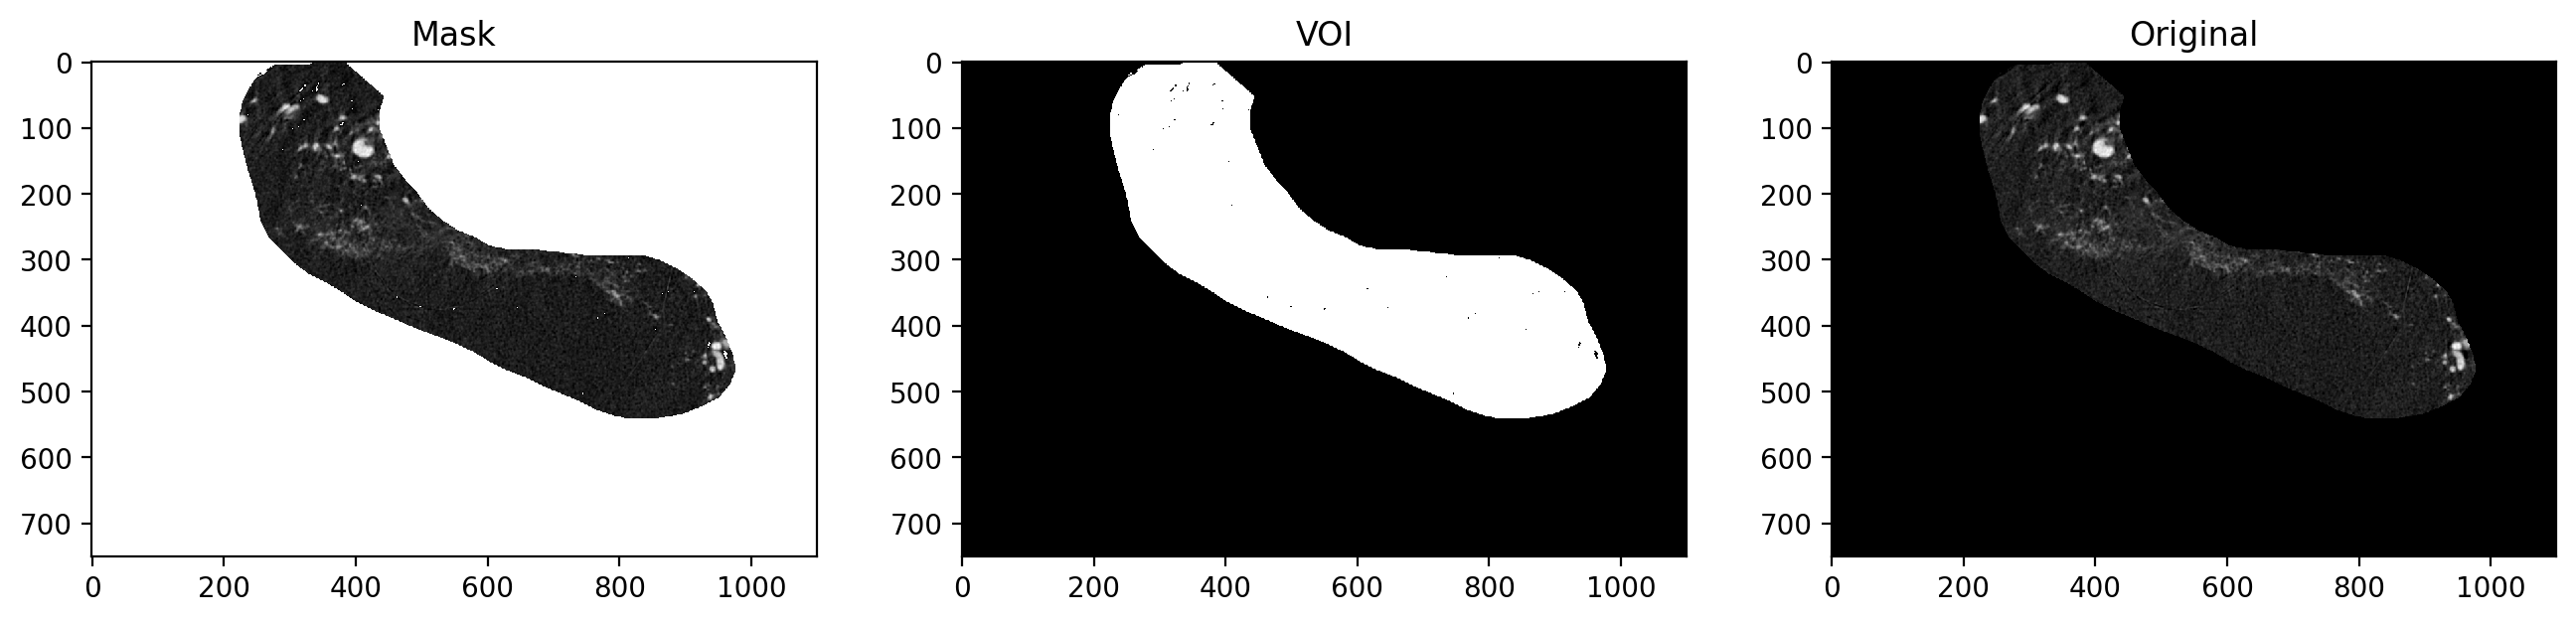

In [155]:
plt.subplot(131)
plt.imshow(Masked[0][100][950:1700,700:1800])
plt.title('Mask')
plt.subplot(132)
plt.imshow(VOIRegion[0][100][950:1700,700:1800])
plt.title('VOI')
plt.subplot(133)
plt.imshow(VOIs[0][100][950:1700,700:1800])
plt.title('Original')
plt.show()

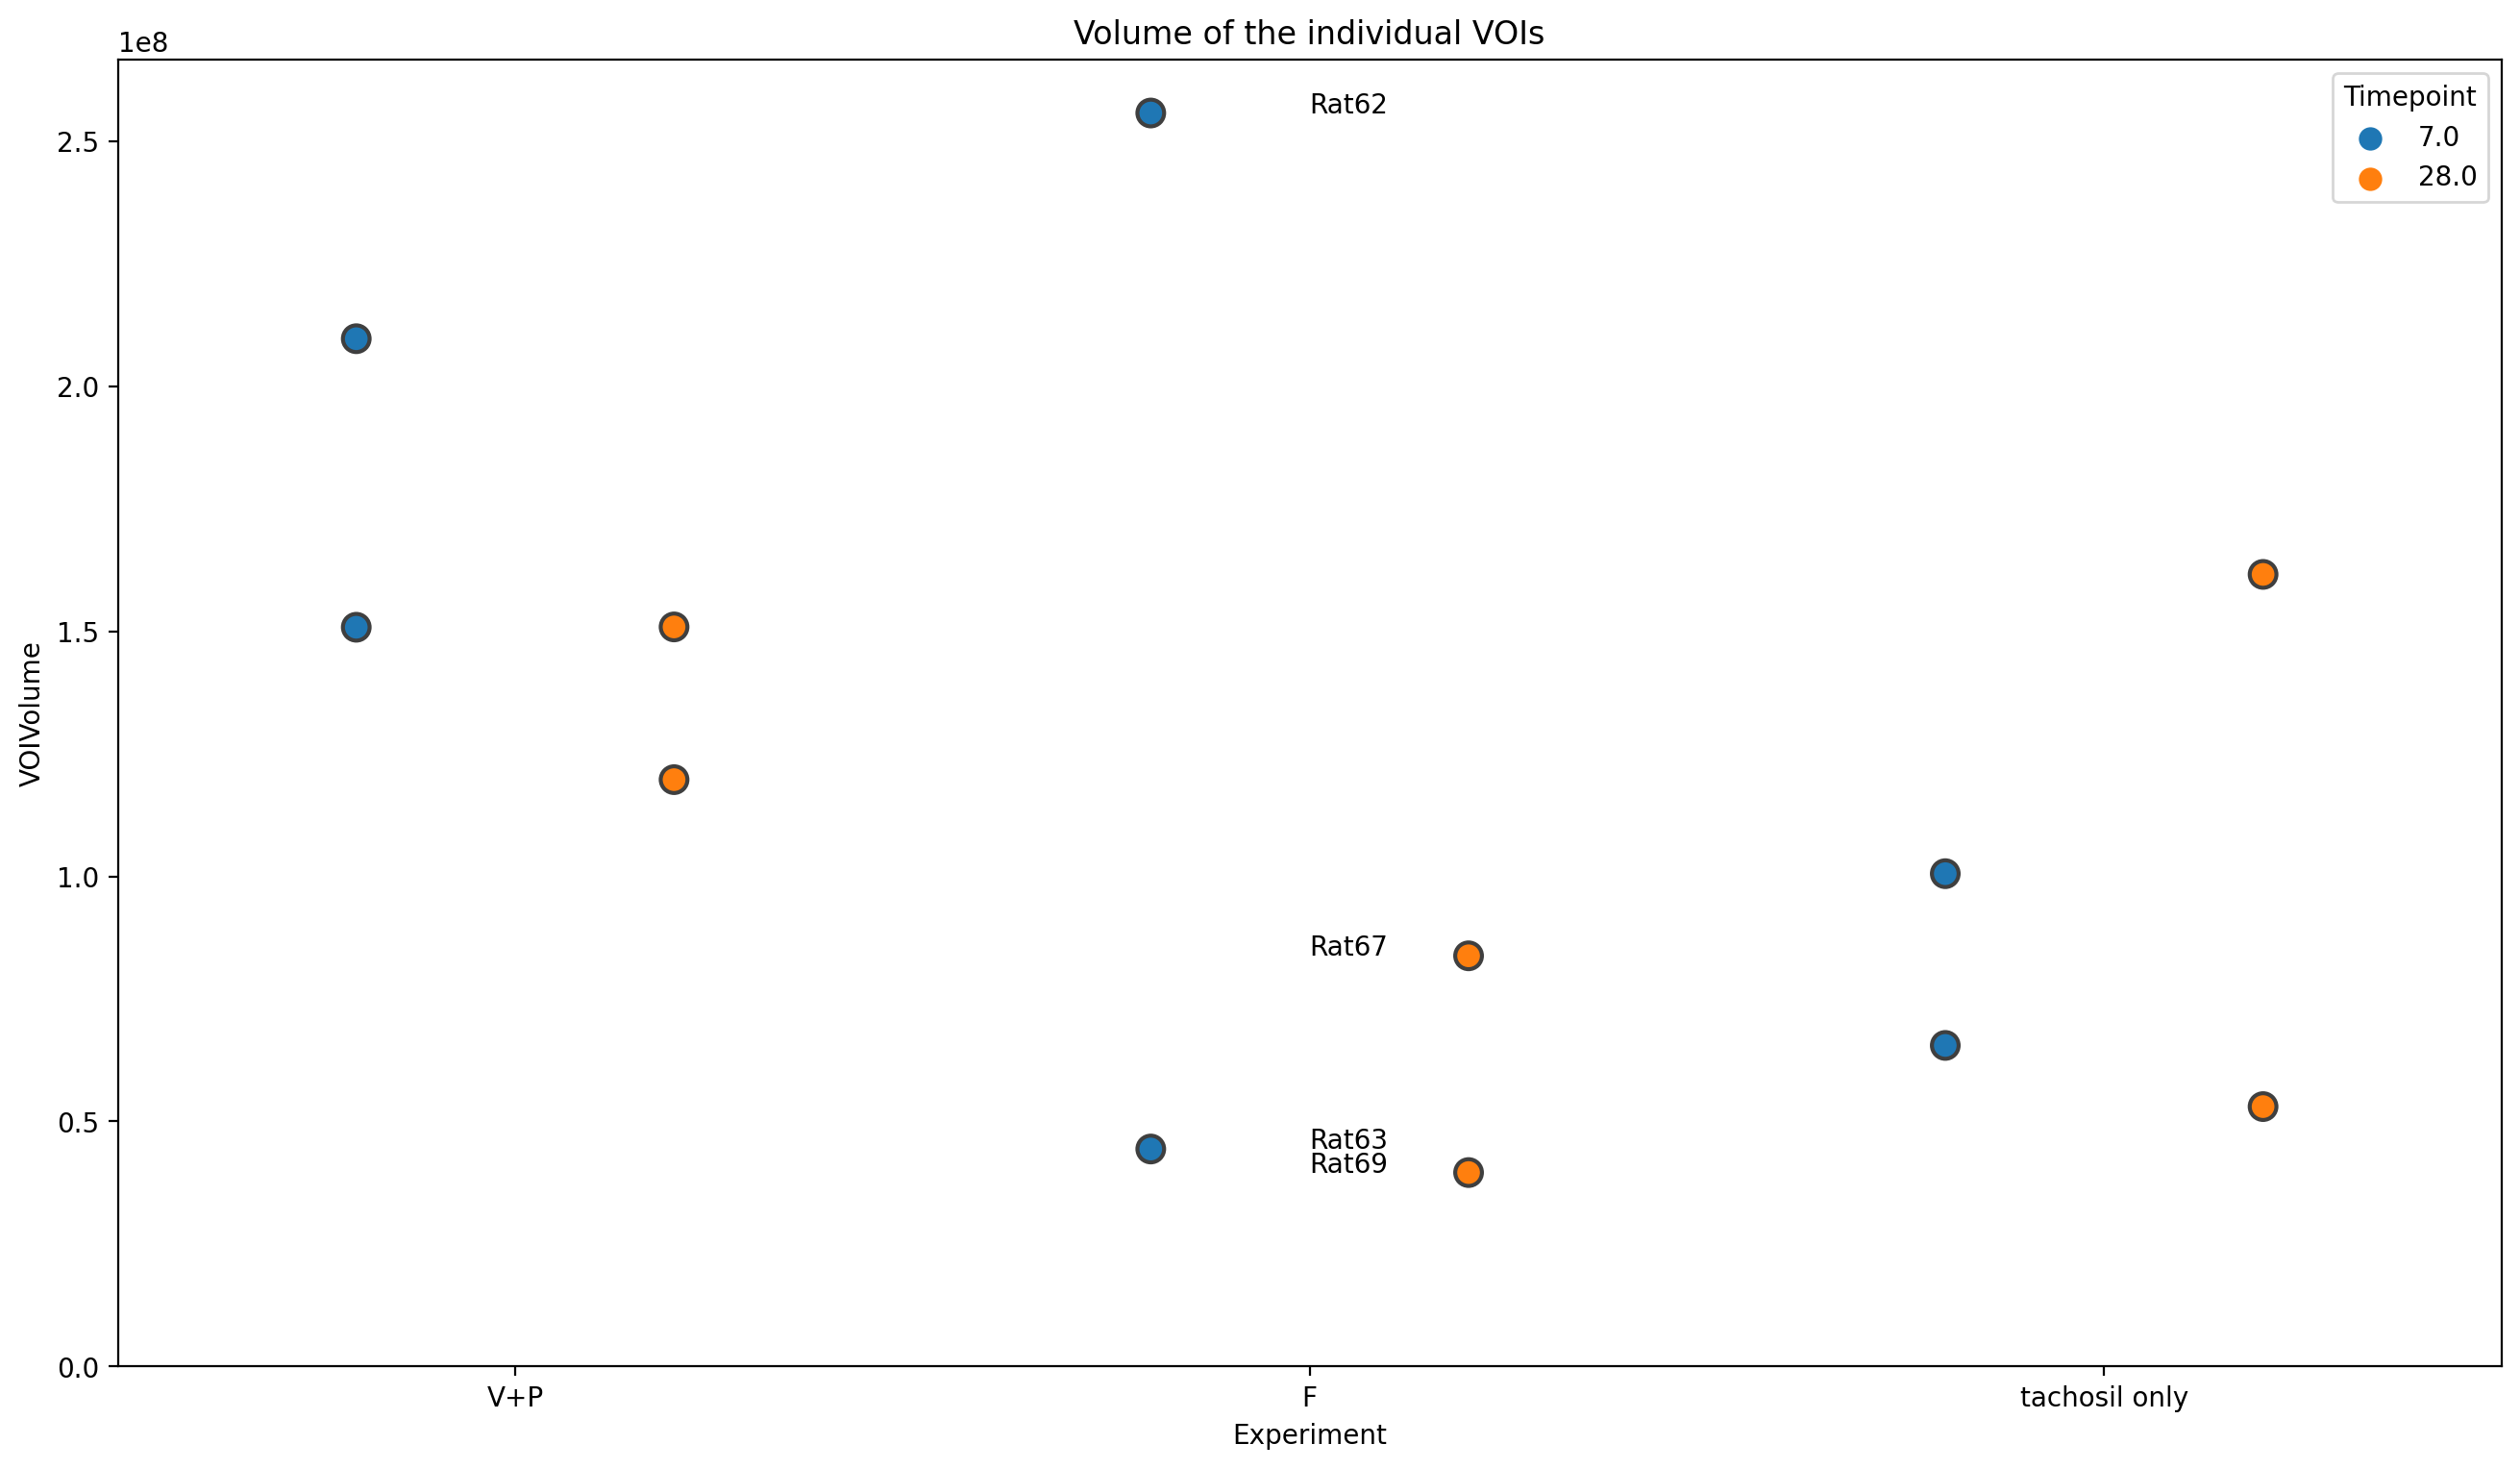

In [158]:
# Plot volume of (selected) VOIs for comparison
seaborn.swarmplot(data=Data,
                  x='Experiment',
                  y='VOIVolume',
                  dodge=True,
                  hue='Timepoint',
                  s=10,
                  linewidth=1.5)
for c,row in Data.iterrows():
    if 'VP' in row.Experiment:
        plt.annotate(row.Sample, (0, row.VOIVolume))
    elif 'F' in row.Experiment:
        plt.annotate(row.Sample, (1, row.VOIVolume))
    elif 'Tacho' in row.Experiment:
        plt.annotate(row.Sample, (2, row.VOIVolume))
plt.ylim(ymin=0)
plt.title('Volume of the individual VOIs')
plt.savefig(os.path.join(OutputDir, 'Volume.VOIs.png'),
            bbox_inches='tight')
plt.show()

In [159]:
asdfasdfasdfasdf==

SyntaxError: invalid syntax (<ipython-input-159-a6099ad12af7>, line 1)

In [350]:
Data.Sample.unique()

array(['Rat60', 'Rat61', 'Rat62', 'Rat63', 'Rat64', 'Rat65', 'Rat66',
       'Rat67', 'Rat68', 'Rat69', 'Rat70', 'Rat71'], dtype=object)

In [351]:
OutputDir

'Output/0c4fcb9'

In [371]:
Data[['Sample',
      'VOIVolume']].to_excel(os.path.join(OutputDir, 'Volume.VOIs.xls'))

In [213]:
# Data.groupby(by=[['Experiment', 'VOI']])['VOIVolume'].describe()[['count',
#                                                                   'mean',
#                                                                   'std',
#                                                                   'min',
#                                                                   'max']]

In [355]:
# Save mean of reconstruction gray values,
# We can use this for getting an overview of the image data
Data['GrayValueMean'] = [m.mean().compute() for m  in Masked]

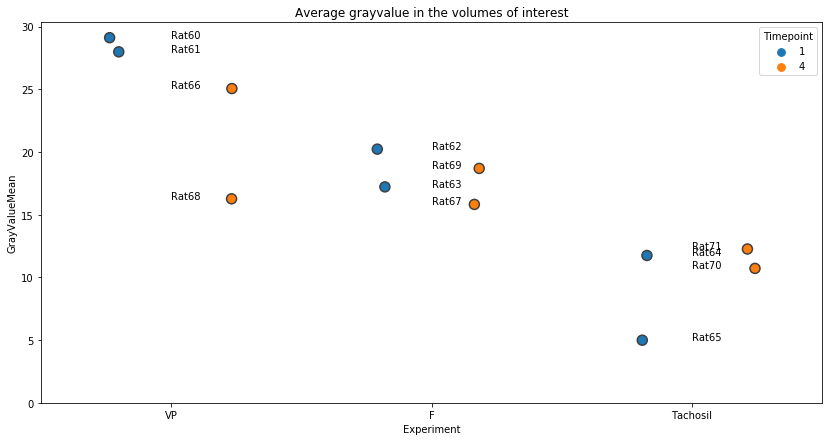

In [372]:
# Plot volume-normalized mean of datasets for comparison
seaborn.stripplot(data=Data, x='Experiment', y='GrayValueMean', hue='Timepoint', s=10, linewidth=1.5, dodge=True)
for c,row in Data.iterrows():
    if 'VP' in row.Experiment:
        plt.annotate(row.Sample, (0, row.GrayValueMean))
    elif 'F' in row.Experiment:
        plt.annotate(row.Sample, (1, row.GrayValueMean))
    elif 'Tacho' in row.Experiment:
        plt.annotate(row.Sample, (2, row.GrayValueMean))
plt.ylim(ymin=0)
plt.title('Average grayvalue in the volumes of interest')
plt.savefig(os.path.join(OutputDir, 'Grayvalues.Mean.VOIs.png'),
            bbox_inches='tight')
plt.show()

In [373]:
Data[['Sample', 'GrayValueMean']].to_excel(os.path.join(OutputDir, 'Grayvalues.Mean.VOIs.xls'))

In [374]:
Data.groupby(by=['Experiment'])['GrayValueMean'].describe()[['count',
                                                             'mean',
                                                             'std',
                                                             'min',
                                                             'max']]

,count,mean,std,min,max
Experiment,,,,,
F,4.0,17.986179,1.897474,15.816835,20.223584
Tachosil,4.0,9.928348,3.353485,4.991514,12.262273
VP,4.0,24.601782,5.815836,16.263256,29.108859


In [375]:
Data['GrayValueMeanNormalizedToVOIVolume'] = [numpy.divide(gvm,
                                                           vv) for gvm, vv in zip(Data['GrayValueMean'],
                                                                                  Data['VOIVolume'])]

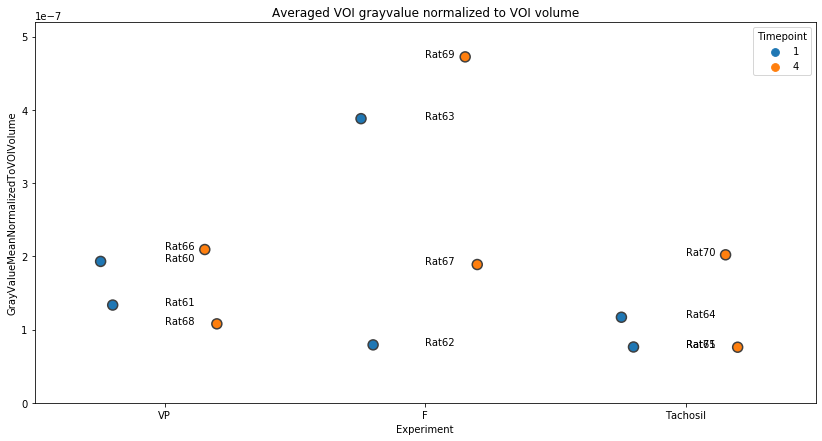

In [376]:
# Plot volume-normalized mean of datasets for comparison
#seaborn.boxplot(data=Data, x='Experiment', y='GrayValueMeanNormalizedToVOIVolume', hue='Timepoint')
seaborn.swarmplot(data=Data, x='Experiment', y='GrayValueMeanNormalizedToVOIVolume', hue='Timepoint', dodge=True, linewidth=1.5, s=10)
for c,row in Data.iterrows():
    if 'VP' in row.Experiment:
        plt.annotate(row.Sample, (0, row.GrayValueMeanNormalizedToVOIVolume))
    elif 'F' in row.Experiment:
        plt.annotate(row.Sample, (1, row.GrayValueMeanNormalizedToVOIVolume))
    elif 'Tacho' in row.Experiment:
        plt.annotate(row.Sample, (2, row.GrayValueMeanNormalizedToVOIVolume))
plt.ylim(ymin=0, ymax=1.1*Data.GrayValueMeanNormalizedToVOIVolume.max())
plt.title('Averaged VOI grayvalue normalized to VOI volume')
plt.savefig(os.path.join(OutputDir, 'Grayvalues.Mean.NormalizedVOI.png'),
            bbox_inches='tight')
plt.show()

In [377]:
OutputDir

'Output/0c4fcb9'

In [387]:
# Thresholds
preset = True
if preset:
    # Set them (from previous calculations)
    Data['Threshold'] = [44, 46, 41, 16, 12, 7, 63, 15, 15, 19, 13, 13]
#     Data['Threshold'] = [41, 45, 41, 12, 13, 19, 13]
else:
    # Calculate Threshold
    Data['Threshold'] = [skimage.filters.threshold_otsu(
        dask.array.ravel(
            dask.array.ma.masked_less(
                rec, 1).compute())) for rec in VOIs]

In [388]:
list(Data.Threshold)

[44, 46, 41, 16, 12, 7, 63, 15, 15, 19, 13, 13]

In [389]:
# Get the mean threshold of all samples
Data['ThresholdMean'] = int(Data['Threshold'].mean())

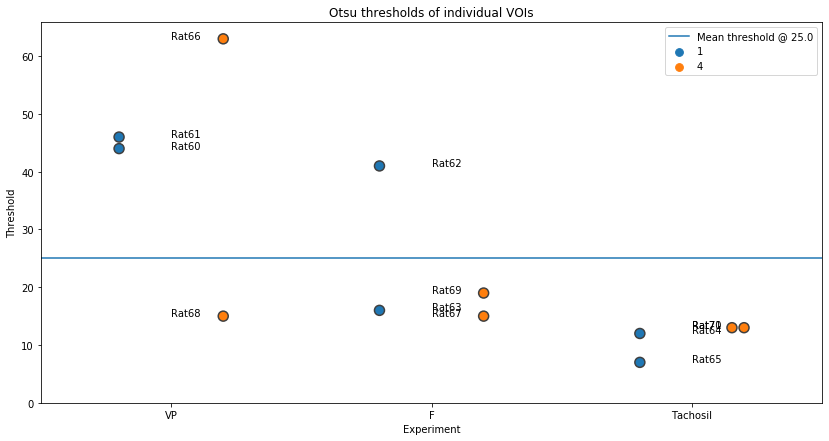

In [390]:
# Plot the thresholds
seaborn.swarmplot(data=Data, x='Experiment', y='Threshold', hue='Timepoint', dodge=True, linewidth=1.5, s=10)
for c,row in Data.iterrows():
    if 'VP' in row.Experiment:
        plt.annotate(row.Sample, (0, row.Threshold))
    elif 'F' in row.Experiment:
        plt.annotate(row.Sample, (1, row.Threshold))
    elif 'Tacho' in row.Experiment:
        plt.annotate(row.Sample, (2, row.Threshold))
plt.axhline(Data['ThresholdMean'].mean(), label='Mean threshold @ %s' % Data['ThresholdMean'].mean())
plt.ylim(ymin=0)
plt.legend()
plt.title('Otsu thresholds of individual VOIs')
plt.savefig(os.path.join(OutputDir, 'Thresholds.png'),
            bbox_inches='tight')
plt.show()

In [391]:
Data[['Sample', 'Threshold']].to_excel(os.path.join(OutputDir, 'Thresholds.xls'))

In [392]:
Data.groupby(by=['Experiment'])['Threshold'].describe()[['count',
                                                         'mean',
                                                         'std',
                                                         'min',
                                                         'max']]

,count,mean,std,min,max
Experiment,,,,,
F,4.0,22.75,12.284814,15.0,41.0
Tachosil,4.0,11.25,2.872281,7.0,13.0
VP,4.0,42.00,19.916492,15.0,63.0


In [393]:
# Threshold the reconstructions individually                                                                                                                           Data.Sample)
Data['OutputNameThresholded'] = [f.replace('.zarr',
                                           '_thresholded_%s.zarr' % str(t).zfill(3)) for f, t in zip(Data['OutputNameVOI'],
                                                                                                     Data['Threshold'])]
for c, row in Data.iterrows():
    if os.path.exists(row['OutputNameThresholded']):  
        print('%2s/%s: Already saved to %s' % (c + 1,
                                               len(Data),
                                               row['OutputNameThresholded'][len(Root):]))
    else:
        print('%2s/%s: Thresholding and saving to %s' % (c + 1,
                                                         len(Data),
                                                         row['OutputNameThresholded'][len(Root):]))
        Thresholded = VOIs[c] > row['Threshold']
        Thresholded.to_zarr(row['OutputNameThresholded'],
                           overwrite=True,
                           compressor=Blosc(cname='zstd', clevel=3, shuffle=Blosc.BITSHUFFLE))    

 1/12: Already saved to /Rat60/overview/rec/Rat60_patch_thresholded_044.zarr
 2/12: Already saved to /Rat61/overview/rec/Rat61_patch_thresholded_046.zarr
 3/12: Already saved to /Rat62/overview/rec/Rat62_patch_thresholded_041.zarr
 4/12: Already saved to /Rat63/overview/rec/Rat63_patch_thresholded_016.zarr
 5/12: Already saved to /Rat64/overview/rec/Rat64_patch_thresholded_012.zarr
 6/12: Already saved to /Rat65/overview/rec/Rat65_patch_thresholded_007.zarr
 7/12: Already saved to /Rat66/overview/rec/Rat66_patch_thresholded_063.zarr
 8/12: Already saved to /Rat67/overview/rec/Rat67_patch_thresholded_015.zarr
 9/12: Already saved to /Rat68/overview/rec/Rat68_patch_thresholded_015.zarr
10/12: Already saved to /Rat69/overview/rec/Rat69_patch_thresholded_019.zarr
11/12: Already saved to /Rat70/overview/rec/Rat70_patch_thresholded_013.zarr
12/12: Already saved to /Rat71/overview/rec/Rat71_patch_thresholded_013.zarr


In [394]:
# Threshold the reconstructions with the mean threshold                                                                                                                           Data.Sample)
Data['OutputNameThresholdedMean'] = [f.replace('.zarr',
                                           '_thresholded_%s.zarr' % str(t).zfill(3)) for f, t in zip(Data['OutputNameVOI'],
                                                                                                     Data['ThresholdMean'])]
for c, row in Data.iterrows():
    if os.path.exists(row['OutputNameThresholdedMean']):  
        print('%2s/%s: Already saved to %s' % (c + 1,
                                               len(Data),
                                               row['OutputNameThresholdedMean'][len(Root):]))
    else:
        print('%2s/%s: Thresholding and saving to %s' % (c + 1,
                                                         len(Data),
                                                         row['OutputNameThresholded'][len(Root):]))
        Thresholded = VOIs[c] > row['ThresholdMean']
        Thresholded.to_zarr(row['OutputNameThresholdedMean'],
                           overwrite=True,
                           compressor=Blosc(cname='zstd', clevel=3, shuffle=Blosc.BITSHUFFLE))    

 1/12: Already saved to /Rat60/overview/rec/Rat60_patch_thresholded_025.zarr
 2/12: Already saved to /Rat61/overview/rec/Rat61_patch_thresholded_025.zarr
 3/12: Already saved to /Rat62/overview/rec/Rat62_patch_thresholded_025.zarr
 4/12: Already saved to /Rat63/overview/rec/Rat63_patch_thresholded_025.zarr
 5/12: Already saved to /Rat64/overview/rec/Rat64_patch_thresholded_025.zarr
 6/12: Already saved to /Rat65/overview/rec/Rat65_patch_thresholded_025.zarr
 7/12: Already saved to /Rat66/overview/rec/Rat66_patch_thresholded_025.zarr
 8/12: Already saved to /Rat67/overview/rec/Rat67_patch_thresholded_025.zarr
 9/12: Already saved to /Rat68/overview/rec/Rat68_patch_thresholded_025.zarr
10/12: Already saved to /Rat69/overview/rec/Rat69_patch_thresholded_025.zarr
11/12: Already saved to /Rat70/overview/rec/Rat70_patch_thresholded_025.zarr
12/12: Already saved to /Rat71/overview/rec/Rat71_patch_thresholded_025.zarr


In [395]:
# Load the DASK arrays of the thresholded samples
individualThreshold = True
if individualThreshold:
    Thresholded = [dask.array.from_zarr(file) for file in Data['OutputNameThresholded']]
    print('Loading individually thresholded stacks')
else:
    Thresholded = [dask.array.from_zarr(file) for file in Data['OutputNameThresholdedMean']]
    print('Loading all stacks with a threshold of %s' % Data.ThresholdMean.unique())

Loading individually thresholded stacks


In [396]:
# DASK
# Read or calculate the middle slices of the thresholded images,
# put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['Thresholded_Mid_' + direction] = [None] * len(VOIs)
for c, row in tqdm.notebook.tqdm(Data.iterrows(),
                                 desc='Middle thresholded images',
                                 total=len(Data)):
    for d, direction in tqdm.notebook.tqdm(enumerate(directions),
                                           desc=row['Sample'],
                                           leave=False,
                                           total=len(directions)):
        outfilepath = os.path.join(row['Folder'],
                                   '%s.Thresholded%03d.Middle.%s.png' % (row['Sample'],
                                                                         row['Threshold'],
                                                                         direction))
        if os.path.exists(outfilepath):
            Data.at[c,'Thresholded_Mid_' + direction] = imageio.imread(outfilepath)
        else:
            # Generate requested axial view
            if 'Axial' in direction:
                Data.at[c,'Thresholded_Mid_' + direction] = Thresholded[c][Data['Size'][c][0]//2]
            if 'Sagittal' in direction:
                Data.at[c,'Thresholded_Mid_' + direction] = Thresholded[c][:,Data['Size'][c][1]//2,:]
            if 'Coronal' in direction:
                Data.at[c,'Thresholded_Mid_' + direction] = Thresholded[c][:,:,Data['Size'][c][2]//2]
            # Save the calculated 'direction' view out
            # Dask only calculates/reads the images here at this point...
            imageio.imwrite(outfilepath, (Data.at[c,'Thresholded_Mid_' + direction].astype('uint8')*255))

In [397]:
# for d, direction in enumerate(directions):
#     for c,row in Data.iterrows():
#         plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)
#         plt.imshow(row['Thresholded_Mid_' + direction])
#         plt.title('%s\nMid-%s\nthresholded slice' % (row['Sample'], direction))
#         plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))    
#         plt.axis('off')
#     plt.show()

In [398]:
# Read or calculate the directional MIPs of the thresholded datasets,
# put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['Thresholded_MIP_' + direction] = [None] * len(VOIs)
for c, row in notebook.tqdm(Data.iterrows(), desc='MIPs', total=len(Data)):
    for d, direction in notebook.tqdm(enumerate(directions),
                                      desc=row['Sample'],
                                      leave=False,
                                      total=len(directions)):
        outfilepath = os.path.join(row['Folder'], '%s.Thresholded.MIP.%s.png' % (row['Sample'], direction))
        if os.path.exists(outfilepath):
            Data.at[c,'Thresholded_MIP_' + direction] = imageio.imread(outfilepath)
        else:
            # Generate MIP
            Data.at[c,'Thresholded_MIP_' + direction] = Thresholded[c].max(axis=d).compute()
            # Save it out
            imageio.imwrite(outfilepath, Data.at[c,'Thresholded_MIP_' + direction].astype('uint8'))            

In [399]:
# # Show thresholded MIP slices
# for c, row in Data.iterrows():
#     for d, direction in enumerate(directions):
#         plt.subplot(1, 3, d + 1)
#         plt.imshow(row['Thresholded_MIP_' + direction])
#         plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
# #         plt.title('%s/%s: %s, %s' % (c + 1,
# #                                      len(Data),
# #                                      row['Sample'],
# #                                      direction + ' MIP'))
#         plt.title('%s, %s' % (row['Sample'], direction + ' MIP'))
#         plt.axis('off')
#     plt.savefig(os.path.join(row['Folder'], row['Sample'] + '.Thresholded.MIPs.png'),
#                 bbox_inches='tight')
#     plt.show()

In [400]:
# Sum the images, so we can see if they contain approximately the same *thresholded* volume
Data['ThresholdedVolume'] = [th.sum().compute() for th in Thresholded]

In [401]:
# Data[['Sample', 'ThresholdedVolume']]

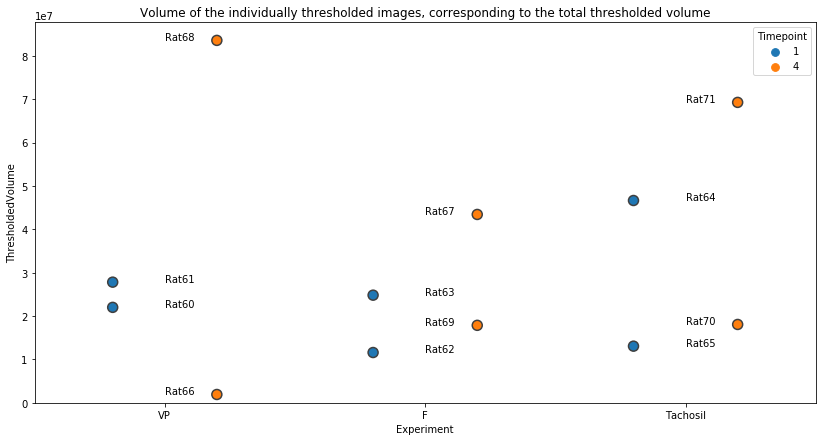

In [402]:
# Plot the thresholded volumes
seaborn.swarmplot(data=Data, x='Experiment', y='ThresholdedVolume', hue='Timepoint', dodge=True, linewidth=1.5, s=10)
for c,row in Data.iterrows():
    if 'VP' in row.Experiment:
        plt.annotate(row.Sample, (0, row.ThresholdedVolume))
    elif 'F' in row.Experiment:
        plt.annotate(row.Sample, (1, row.ThresholdedVolume))
    elif 'Tacho' in row.Experiment:
        plt.annotate(row.Sample, (2, row.ThresholdedVolume))
plt.ylim(ymin=0)
if individualThreshold:
    plt.title('Volume of the individually thresholded images, corresponding to the total thresholded volume')
    plt.savefig(os.path.join(OutputDir, 'Volumes.Thresholded.ThresholdedIndividually.png'),
                bbox_inches='tight')    
else:
    plt.title('Volume of the images thresholded all equally, corresponding to the total thresholded volume')    
    plt.savefig(os.path.join(OutputDir, 'Volumes.Thresholded.ThresholdedEqually.png'),
                bbox_inches='tight')    
plt.show()

In [403]:
OutputDir

'Output/0c4fcb9'

In [404]:
# Data[['Sample', 'Experiment', 'Threshold', 'ThresholdedVolume', 'GrayValueMean']]

In [405]:
Data['GrayValueMeanNormalizedToThresholdedVolume'] = [numpy.divide(gvm,
                                                                   tv) for gvm, tv in zip(Data['GrayValueMean'],
                                                                                          Data['ThresholdedVolume'])]

In [410]:
# view(Thresholded[3].astype('uint8'))

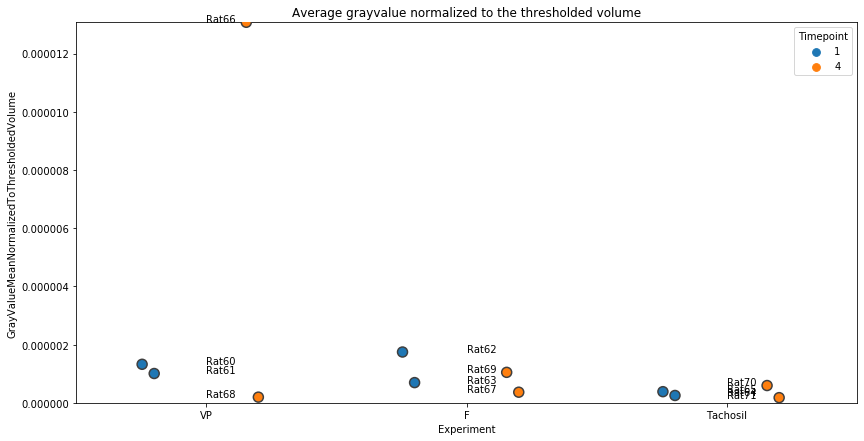

In [411]:
# Plot volume-normalized mean of datasets for comparison
seaborn.swarmplot(data=Data, x='Experiment', y='GrayValueMeanNormalizedToThresholdedVolume', hue='Timepoint', dodge=True, linewidth=1.5, s=10)
for c,row in Data.iterrows():
    if 'VP' in row.Experiment:
        plt.annotate(row.Sample, (0, row.GrayValueMeanNormalizedToThresholdedVolume))
    elif 'F' in row.Experiment:
        plt.annotate(row.Sample, (1, row.GrayValueMeanNormalizedToThresholdedVolume))
    elif 'Tacho' in row.Experiment:
        plt.annotate(row.Sample, (2, row.GrayValueMeanNormalizedToThresholdedVolume))
plt.ylim(ymin=0, ymax=Data.GrayValueMeanNormalizedToThresholdedVolume.max())
if individualThreshold:
    plt.title('Average grayvalue normalized to the thresholded volume')
    plt.savefig(os.path.join(OutputDir, 'Grayvalues.Mean.NormalizedToThresholded.ThresholdedIndividually.png'),
            bbox_inches='tight')   
else:
    plt.title('Average grayvalue normalized to the volume thresholded all with the same threshold')        
    plt.savefig(os.path.join(OutputDir, 'Grayvalues.Mean.NormalizedToThresholded.ThresholdedEqually.png'),
                bbox_inches='tight')    
plt.show()

In [412]:
# # Plot volume-normalized mean of datasets for comparison
# seaborn.swarmplot(data=Data, x='Experiment', y='GrayValueMeanNormalizedToThresholdedVolume', hue='Timepoint', dodge=True, linewidth=1.5, s=10)
# for c,row in Data.iterrows():
#     if 'VP' in row.Experiment:
#         plt.annotate(row.Sample, (0, row.GrayValueMeanNormalizedToThresholdedVolume))
#     elif 'F' in row.Experiment:
#         plt.annotate(row.Sample, (1, row.GrayValueMeanNormalizedToThresholdedVolume))
#     elif 'Tacho' in row.Experiment:
#         plt.annotate(row.Sample, (2, row.GrayValueMeanNormalizedToThresholdedVolume))
# plt.ylim(ymin=0, ymax=0.000003)
# plt.savefig(os.path.join(OutputDir, 'Grayvalues.Mean.NormalizedToThresholded.Without66.png'),
#             bbox_inches='tight')
# plt.show()

In [413]:
# view(Thresholded[0].compute().astype('uint8'))

# Characterization of vessel diameter
- Fill the vessels/ventricle (with something like `skimage.fill.small.holes`)
    This doesn't seem to be working in the 3D case (maybe because of small holes) but we just loop through every slice and do it for each and everyone of it. This is bad code, but works :)
- Remove all the big stuff with `tophat`
- Calculate the distance-transformation or skeleton

In [414]:
def ourfiller(image, verbose=False):
    '''
    Since we cannot seem to get remove_small_holes to work in 3D, we simply brute-force it on every slice.
    Thanks to `tqdm_notebook` we also get a progress bar...
    And afterwards generate an output array.
    '''
    filled = [skimage.morphology.remove_small_holes(s, area_threshold=1e4) for
              s in tqdm.notebook.tqdm(image, leave=False)]
    if verbose:
        plt.subplot(131)
        plt.imshow(image[len(filled)//2,:,:])
        plt.title('Original')
        plt.subplot(132)
        plt.imshow(filled[len(filled)//2,:,:])       
        plt.title('Filled (output)')
        plt.subplot(133)        
        plt.imshow(image[len(filled)//2,:,:], alpha=0.5)       
        plt.imshow(filled[len(filled)//2,:,:], cmap='viridis', alpha=0.5)       
        plt.title('Overlay')        
        plt.show()    
    return(filled)

In [415]:
# def pad_edges(image, howmanypixels=25):
#     '''There *has* to be a better way to set the edges to one, but I havent found one'''
#     closed = image.copy()
#     closed[:howmanypixels,:,:] = True
#     closed[:,:howmanypixels,:] = True
#     closed[:,:,:howmanypixels] = True
#     closed[-howmanypixels:,:,:] = True
#     closed[:,-howmanypixels:,:] = True
#     closed[:,:,-howmanypixels:] = True
#     return(closed)

In [416]:
# def fill_hollow_bones(image, verbose=False):
#     '''
#     We flood-fill the image from one edge.
#     Then we add the inversion of this to the original image and thus filled all the long bones.
#     '''
#     dilated = skimage.morphology.binary_dilation(
#         skimage.morphology.binary_dilation(
#             skimage.morphology.binary_dilation(image)))
#     closed = pad_edges(dilated)
#     # Flood fill from one edge and invert the (boolean) result
#     flooded = ~skimage.morphology.flood_fill(closed.astype('int'),
#                                              seed_point=(30,30,30),
#                                              new_value=1).astype('bool')
#     # Add the inverted result to the original image, filling the long bones
#     filled = numpy.add(image, skimage.morphology.binary_dilation(
#         skimage.morphology.binary_dilation(
#             skimage.morphology.binary_dilation(flooded))))
#     if verbose:
#         plt.subplot(131)
#         plt.imshow(image[len(filled)//2,:,:])
#         plt.title('original')
#         plt.subplot(132)
#         plt.imshow(flooded[len(filled)//2,:,:])       
#         plt.title('flooded')
#         plt.subplot(133)        
#         plt.imshow(image[len(filled)//2,:,:], alpha=0.5)       
#         plt.imshow(filled[len(filled)//2,:,:], cmap='viridis', alpha=0.5)       
#         plt.title('filled (output)')        
#         plt.show()
#     return(filled)

In [426]:
# Calculate the flood-filled image
# Since this takes a while, we don't do it in a Pythonic way
# e.g. (Flooded = [ourfiller(t, verbose=True) for t in Tresholded])
# but in a loop with saving in between.
Data['OutputNameFlooded'] = [f.replace('.zarr', '_flooded.zarr') for f in Data['OutputNameThresholded']]
for c, row in Data.iterrows():
    if not os.path.exists(row['OutputNameFlooded']):  
        print('%2s/%s: %s: Filling holes' % (c + 1,
                                             len(Data),
                                             row['Sample']))
        Flooded = ourfiller(Thresholded[c].compute())
        Flooded = da.stack(Flooded[:])
        print('%11s: Saving to %s' % (row['Sample'],
                                      row['OutputNameFlooded'][len(Root):]))
        Flooded.to_zarr(row['OutputNameFlooded'],
                        overwrite=True,
                        compressor=Blosc(cname='zstd', clevel=3, shuffle=Blosc.BITSHUFFLE))          

In [427]:
# Load the DASK arrays with the filled samples
Flooded = [dask.array.from_zarr(file) for file in Data['OutputNameFlooded']]

In [428]:
# DASK
# Read or calculate the middle slices of the flooded images,
# put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['Flooded_Mid_' + direction] = [None] * len(VOIs)
for c, row in tqdm.notebook.tqdm(Data.iterrows(),
                                 desc='Middle flooded images',
                                 total=len(Data)):
    for d, direction in tqdm.notebook.tqdm(enumerate(directions),
                                           desc=row['Sample'],
                                           leave=False,
                                           total=len(directions)):
        outfilepath = os.path.join(row['Folder'],
                                   '%s.Thresholded%03d.Flooded.Middle.%s.png' % (row['Sample'],
                                                                                 row['Threshold'],
                                                                                 direction))
        if os.path.exists(outfilepath):
            Data.at[c,'Flooded_Mid_' + direction] = imageio.imread(outfilepath)
        else:
            # Generate requested axial view
            if 'Axial' in direction:
                Data.at[c,'Flooded_Mid_' + direction] = Flooded[c][Data['Size'][c][0]//2]
            if 'Sagittal' in direction:
                Data.at[c,'Flooded_Mid_' + direction] = Flooded[c][:,Data['Size'][c][1]//2,:]
            if 'Coronal' in direction:
                Data.at[c,'Flooded_Mid_' + direction] = Flooded[c][:,:,Data['Size'][c][2]//2]
            # Save the calculated 'direction' view out
            # Dask only calculates/reads the images here at this point...
            imageio.imwrite(outfilepath,
                            (Data.at[c,'Flooded_Mid_' + direction].astype('uint8')*255))

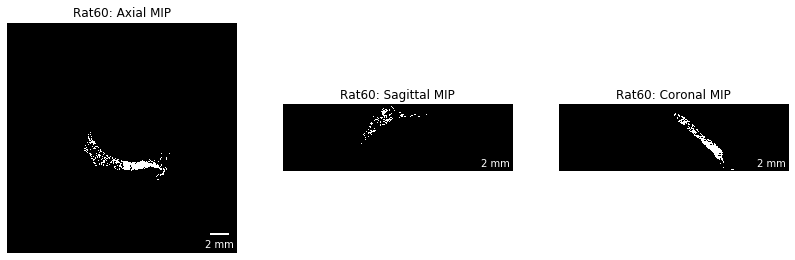

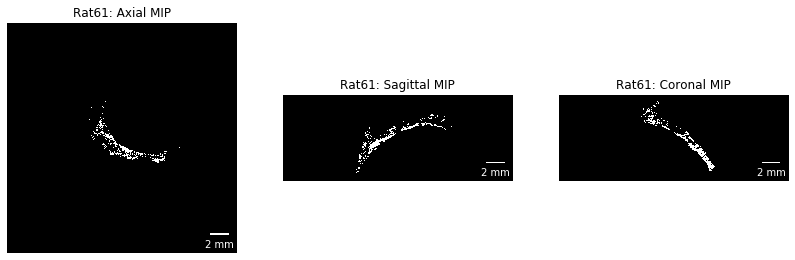

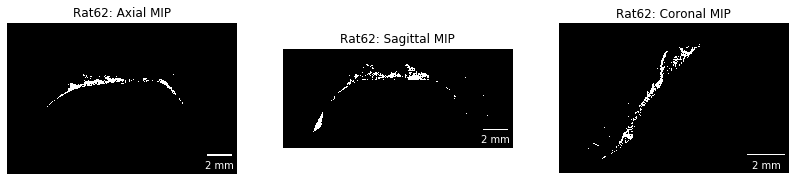

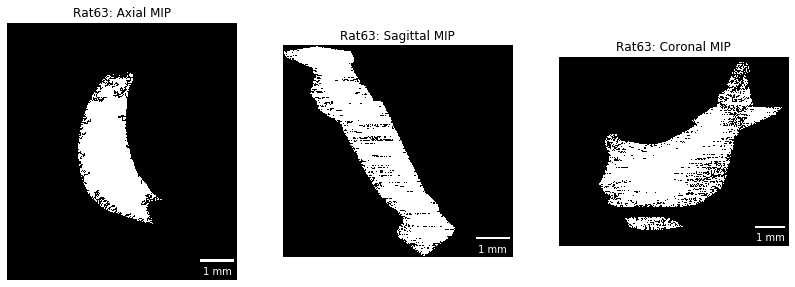

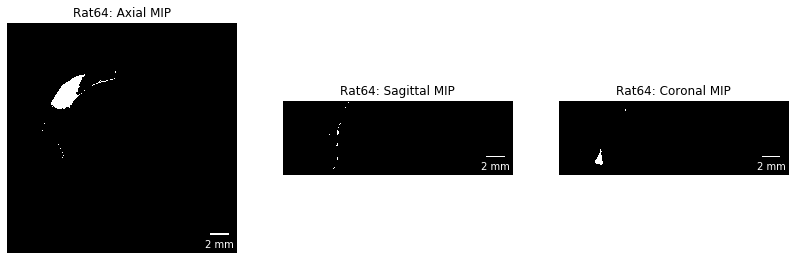

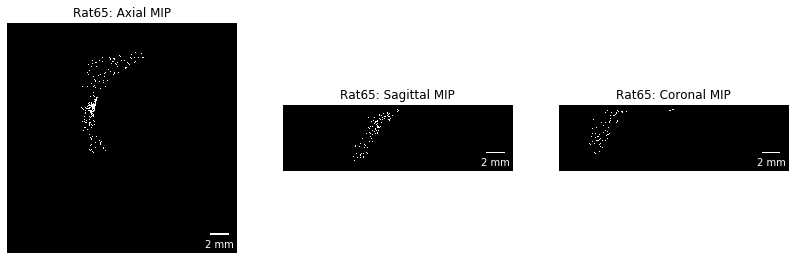

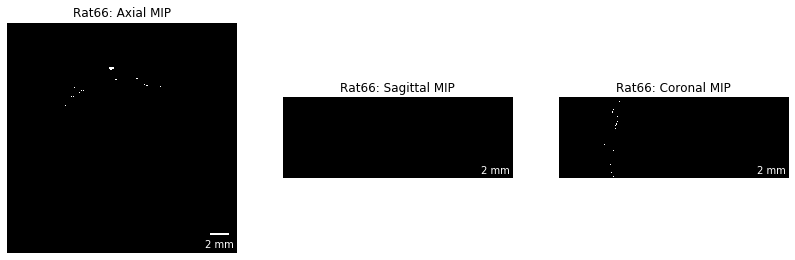

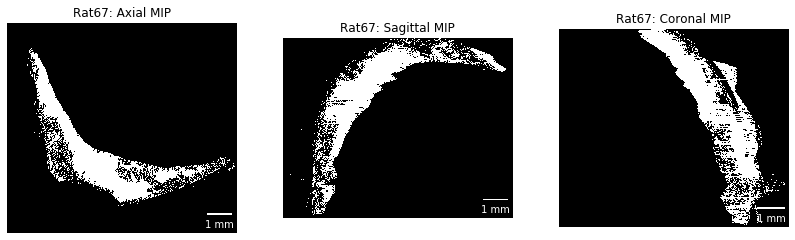

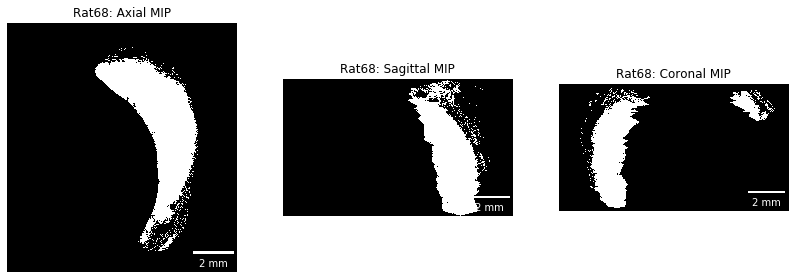

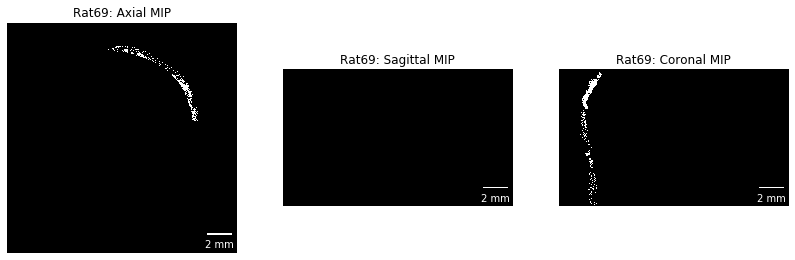

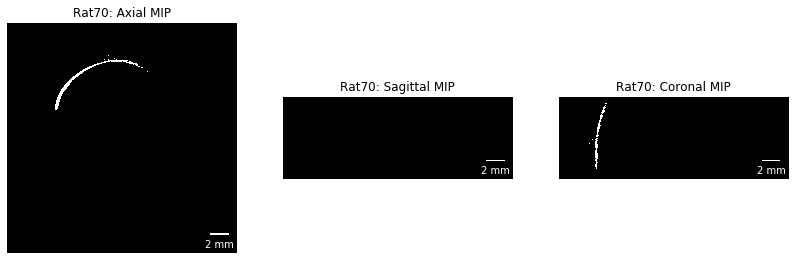

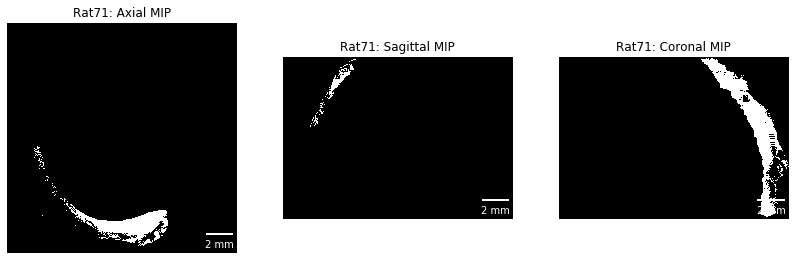

In [429]:
# Show middle flood-filled images
for c, row in Data.iterrows():
    for d, direction in enumerate(directions):
        plt.subplot(1, 3, d + 1)
        plt.imshow(row['Flooded_Mid_' + direction])
        plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
#         plt.title('%s/%s: %s, %s' % (c + 1,
#                                      len(Data),
#                                      row['Sample'],
#                                      direction + ' MIP'))
        plt.title('%s: %s' % (row['Sample'],
                              direction + ' MIP'))
        
        plt.axis('off')
    plt.savefig(os.path.join(row['Folder'], row['Sample'] + '.Flooded.MiddleSlices.png'),
                bbox_inches='tight')
    plt.show()    

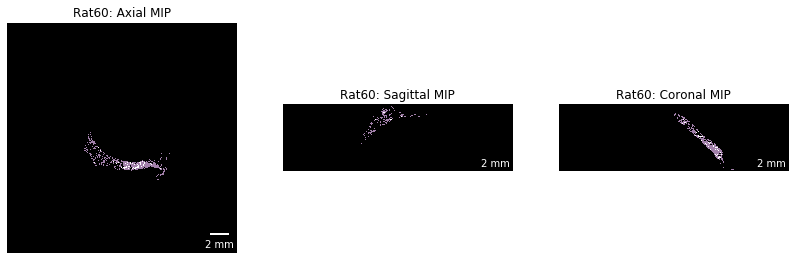

In [ ]:
# Show middle flood-filled images with overlay
for c, row in Data.iterrows():
    for d, direction in enumerate(directions):
        plt.subplot(1, 3, d + 1)
        plt.imshow(row['Flooded_Mid_' + direction])
        plt.imshow(dask.array.ma.masked_less(row['Thresholded_Mid_' + direction], 1), alpha=0.5, cmap='viridis')        
        plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
#         plt.title('%s/%s: %s, %s' % (c + 1,
#                                      len(Data),
#                                      row['Sample'],
#                                      direction + ' MIP'))
        plt.title('%s: %s' % (row['Sample'],
                              direction + ' MIP'))
        
        plt.axis('off')
    plt.savefig(os.path.join(row['Folder'], row['Sample'] + '.Flooded.Overlay.MiddleSlices.png'),
                bbox_inches='tight')
    plt.show()

In [ ]:
# plt.imshow(Data['Thresholded_Mid_Axial'][0])
# plt.imshow(dask.array.ma.masked_less(Data['Flooded_Mid_Axial'][0], 1), alpha=0.5, cmap='viridis')

In [ ]:
# Show middle axis flooded images
for d,direction in enumerate(directions):
    for c,row in Data.iterrows():
        plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)
        plt.imshow(row['Flooded_Mid_' + direction])
        plt.imshow(dask.array.ma.masked_less(row['Thresholded_Mid_' + direction], 1), alpha=0.5, cmap='viridis')
        plt.title('Middle %s slice of tophat of\n%s together with original' % (direction, row['Sample']))
        plt.gca().add_artist(ScaleBar(Data['Voxelsize'][c], 'um'))    
        plt.axis('off')
    plt.show()

In [ ]:
# plt.subplot(121)
# plt.imshow(Data['Thresholded_Mid_' + direction][1])
# plt.subplot(122)
# plt.imshow(Data['Flooded_Mid_' + direction][1])

In [ ]:
Flooded[0]

In [ ]:
Reconstructions[0]

In [ ]:
# Get the white tophat
# https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.white_tophat
# e.g. the bright spots of the image that are smaller than the structuring element.
# We use a ball-shaped (sphere) structuring element
# Again, since this takes a *long* while, we don't do it nice and pythonic,
# but in a loop with intermediate saving
# e.g. not (Tophat = [skimage.morphology.white_tophat(f, selem=skimage.morphology.ball(7)) for f in Flooded])
# but
tophatselem = 5
Data['OutputNameTophat'] = [f.replace('.zarr', '_tophat_%s.zarr' % tophatselem) for f in Data['OutputNameFlooded']]
Tophat = [numpy.nan for file in Data['OutputNameTophat']]
for c, row in Data.iterrows():
    if os.path.exists(row['OutputNameTophat']):
        print('%2s/%s: Already saved to %s' % (c + 1,
                                               len(Data),
                                               row['OutputNameTophat'][len(Root):]))
    else:
        print('%2s/%s: %s: Calculating white thophat with a "selem" of %s' % (c + 1,
                                                                              len(Data),
                                                                              row['Sample'].rjust(Data['SampleNameLength'].max()),
                                                                              tophatselem))
        Tophat = skimage.morphology.white_tophat(Flooded[c].compute(),
                                                 selem=skimage.morphology.ball(tophatselem))
        Tophat = da.stack(Tophat[:])        
        print('%11s: Saving to %s' % (row['Sample'].rjust(Data['SampleNameLength'].max()),
                                      row['OutputNameTophat'][len(Root):]))
        Tophat.to_zarr(row['OutputNameTophat'],
                       overwrite=True,
                       compressor=Blosc(cname='zstd', clevel=3, shuffle=Blosc.BITSHUFFLE))          

In [ ]:
#img = Thresholded[1][1250:-1350,100:-100,100:-100].compute()

In [ ]:
# 2D
#tophat = skimage.morphology.white_tophat(a, selem=skimage.morphology.disk(33))

In [ ]:
# 2D
#plt.subplot(131)
#plt.imshow(a)
#plt.subplot(132)
#plt.imshow(tophat)
#plt.subplot(133)
#plt.imshow(numpy.bitwise_xor(a,
#                             tophat), alpha=0.5)
#plt.imshow(tophat, cmap='viridis', alpha=0.5)
#plt.show()

In [ ]:
# Calculate 3D topat
#tophat = skimage.morphology.white_tophat(img, selem=skimage.morphology.ball(11))

In [ ]:
#whichslice = numpy.shape(img)[0]//2
#plt.subplot(131)
#plt.imshow(img[whichslice])
#plt.subplot(132)
#plt.imshow(tophat[whichslice])
#plt.subplot(133)
#plt.imshow(numpy.bitwise_xor(img[whichslice],
#                             tophat[whichslice]), alpha=0.5)
#plt.imshow(tophat[whichslice], cmap='viridis', alpha=0.5)

In [ ]:
# Load the DASK arrays with the tophat-filtered samples (e.g. only containing the smaller vessels)
Tophat = [dask.array.from_zarr(file) for file in Data['OutputNameTophat']]

In [ ]:
# DASK
# Read or calculate the middle slices of the Tophat images,
# put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['Tophat_Mid_' + direction] = [None] * len(VOIs)
for c, row in tqdm.notebook.tqdm(Data.iterrows(), desc='Middle tophat images', total=len(Data)):
    for d, direction in tqdm.notebook.tqdm(enumerate(directions),
                                      desc=row['Sample'],
                                      leave=False,
                                      total=len(directions)):
        outfilepath = os.path.join(row['Folder'],
                                   '%s.Thresholded%03d.Tophat.Middle.%s.png' % (row['Sample'],
                                                                                row['Threshold'],
                                                                                 direction))
        if os.path.exists(outfilepath):
            Data.at[c,'Tophat_Mid_' + direction] = imageio.imread(outfilepath)
        else:
            # Generate requested axial view
            if 'Axial' in direction:
                Data.at[c,'Tophat_Mid_' + direction] = Tophat[c][Data['Size'][c][0]//2]
            if 'Sagittal' in direction:
                Data.at[c,'Tophat_Mid_' + direction] = Tophat[c][:,Data['Size'][c][1]//2,:]
            if 'Coronal' in direction:
                Data.at[c,'Tophat_Mid_' + direction] = Tophat[c][:,:,Data['Size'][c][2]//2]
            # Save the calculated 'direction' view out
            # Dask only calculates/reads the images here at this point...
            imageio.imwrite(outfilepath, (Data.at[c,'Tophat_Mid_' + direction].astype('uint8')*255))

In [ ]:
# Show middle flood-filled images with overlay
for c, row in Data.iterrows():
    for d, direction in enumerate(directions):
        plt.subplot(1, 3, d + 1)
        plt.imshow(row['Tophat_Mid_' + direction])
        plt.imshow(dask.array.ma.masked_less(row['Thresholded_Mid_' + direction], 1), alpha=0.5, cmap='viridis')        
        plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
#         plt.title('%s/%s: %s, %s' % (c + 1,
#                                      len(Data),
#                                      row['Sample'],
#                                      direction + ' MIP'))
        plt.title('%s: %s' % (row['Sample'],
                              direction + ' MIP'))
        
        plt.axis('off')
    plt.savefig(os.path.join(row['Folder'], row['Sample'] + '.Tophat.Overlay.MiddleSlices.png'),
                bbox_inches='tight')
    plt.show()

In [ ]:
# Show middle slices of tophat data
for d,direction in enumerate(directions):
    for c,row in Data.iterrows():
        plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)
        plt.imshow(row['Thresholded_Mid_' + direction])
        plt.imshow(dask.array.ma.masked_less(row['Tophat_Mid_' + direction], 1), alpha=0.5, cmap='viridis')
        plt.title('Middle %s slice of tophat of\n%s together with original' % (direction, row['Sample']))
        plt.gca().add_artist(ScaleBar(Data['Voxelsize'][c], 'um'))    
        plt.axis('off')
    plt.show()

In [ ]:
# Show overlay
# for c, direction in enumerate(directions):
#     print(c, direction)    
#     if c:
#         plt.imshow(numpy.rot90(center, axes=(0,c))[len(flooded)//2,:,:], alpha=0.33)
#         plt.imshow(numpy.rot90(flooded, axes=(0,c))[len(flooded)//2,:,:], alpha=0.33, cmap='magma')
#         plt.imshow(numpy.rot90(tophat, axes=(0,c))[len(flooded)//2,:,:], alpha=0.33, cmap='viridis')
#     else:
#         plt.imshow(center[len(flooded)//2,:,:], alpha=0.33)
#         plt.imshow(flooded[len(flooded)//2,:,:], alpha=0.33, cmap='magma')
#         plt.imshow(tophat[len(flooded)//2,:,:], alpha=0.33, cmap='viridis')
#     plt.gca().add_artist(ScaleBar(Data['Voxelsize'][0], 'um'))
#     plt.axis('off')
#     plt.savefig('Overlay-%s.png' % direction, bbox_inches='tight')  
#     plt.show()

In [ ]:
# Calculate the skeletonization
# By multiplying them later on we get a color-coded medial axis transformation
# This conforms to what we would expect from 'skimage.morphology.medial_axis(image, return_distance=True)' which does *not* work for 3D images
Data['OutputNameSkeleton'] = [f.replace('.zarr', '_skeleton.zarr') for f in Data['OutputNameTophat']]
for c, row in Data.iterrows():
    if os.path.exists(row['OutputNameSkeleton']):  
        print('%2s/%s: Already saved to %s' % (c + 1,
                                               len(Data),
                                               row['OutputNameSkeleton'][len(Root):]))
    else:
        print('%2s/%s: %s: Calculating skeletonization' % (c + 1,
                                                           len(Data),
                                                           row['Sample'].rjust(Data['SampleNameLength'].max())))
        Skeleton = skimage.morphology.skeletonize_3d(Tophat[c])
        Skeleton = da.stack(Skeleton[:])
        print('%11s: Saving to %s' % (row['Sample'].rjust(Data['SampleNameLength'].max()),
                                     row['OutputNameSkeleton'][len(Root):]))
        Skeleton.to_zarr(row['OutputNameSkeleton'],
                         overwrite=True,
                         compressor=Blosc(cname='zstd', clevel=3, shuffle=Blosc.BITSHUFFLE))          

In [ ]:
# Load the DASK arrays with the skeletonized images
Skeleton = [dask.array.from_zarr(file) for file in Data['OutputNameSkeleton']]

In [ ]:
# Read or calculate the middle slices of the Skeletonization images,
# put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['Skeleton_Mid_' + direction] = [None] * len(VOIs)
for c, row in tqdm.notebook.tqdm(Data.iterrows(), desc='Middle skeleton images', total=len(Data)):
    for d, direction in tqdm.notebook.tqdm(enumerate(directions),
                                      desc=row['Sample'],
                                      leave=False,
                                      total=len(directions)):
        outfilepath = os.path.join(row['Folder'],
                                   '%s.Thresholded%03d.Skeleton.Middle.%s.png' % (row['Sample'],
                                                                                  row['Threshold'],
                                                                                  direction))
        if os.path.exists(outfilepath):
            Data.at[c,'Skeleton_Mid_' + direction] = imageio.imread(outfilepath)
        else:
            # Generate requested axial view
            if 'Axial' in direction:
                Data.at[c,'Skeleton_Mid_' + direction] = Skeleton[c][Data['Size'][c][0]//2]
            if 'Sagittal' in direction:
                Data.at[c,'Skeleton_Mid_' + direction] = Skeleton[c][:,Data['Size'][c][1]//2,:]
            if 'Coronal' in direction:
                Data.at[c,'Skeleton_Mid_' + direction] = Skeleton[c][:,:,Data['Size'][c][2]//2]
            # Save the calculated 'direction' view out
            # Dask only calculates/reads the images here at this point...
            imageio.imwrite(outfilepath, Data.at[c,'Skeleton_Mid_' + direction].astype('uint8'))

In [ ]:
# Show middle skeletonized images with overlay
for c, row in Data.iterrows():
    for d, direction in enumerate(directions):
        plt.subplot(1, 3, d + 1)
        plt.imshow(row['Mid_' + direction])
        plt.imshow(dask.array.ma.masked_less(row['Skeleton_Mid_' + direction], 1), alpha=0.5, cmap='viridis')        
        plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
#         plt.title('%s/%s: %s, %s' % (c + 1,
#                                      len(Data),
#                                      row['Sample'],
#                                      direction + ' MIP'))
        plt.title('%s: %s' % (row['Sample'],
                              direction + ' MIP'))
        
        plt.axis('off')
    plt.savefig(os.path.join(row['Folder'], row['Sample'] + '.Skeleton.Overlay.MiddleSlices.png'),
                bbox_inches='tight')
    plt.show()

In [ ]:
for d,direction in enumerate(directions):
    for c,row in Data.iterrows():
        plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)
        plt.imshow(row['Tophat_Mid_' + direction])
        plt.imshow(row['Skeleton_Mid_' + direction], alpha=0.5, cmap='viridis')
        plt.title('Middle %s slice of Skeletonization of\n%s together with tophat' % (direction, row['Sample']))
        plt.gca().add_artist(ScaleBar(Data['Voxelsize'][c], 'um'))    
        plt.axis('off')
    plt.show()

In [ ]:
#a, b = scipy.ndimage.morphology.distance_transform_edt(Tophat[0][900:1000], sampling=10)

In [ ]:
#numpy.shape(a)

In [ ]:
#plt.imshow(a[5])

In [ ]:
#Tophat[0][800:-800,800:-800,800:-800]

In [ ]:
Tophat[1]

In [ ]:
Data[['Folder',
      'Sample',
#       'Scan',
      'SampleNameLength',
      'ScanNameLength',
      'Experiment',
      'Timepoint',
      'LogFile',
#       'VOIFolders',
      'VOIFolder',
      'Voxelsize',
#       'VOISlices',
      'Number of VOI slices',
      'Size',
      'VOIVolume',
      'GrayValueMean',
      'GrayValueMeanNormalizedToVOIVolume',
      'Threshold',
      'ThresholdMean',
      'ThresholdedVolume',
      'GrayValueMeanNormalizedToThresholdedVolume']].to_excel(os.path.join(OutputDir, 'Data_' + get_git_hash() + '.xls'))

In [ ]:
# for i in Data:
#     print(i)

In [ ]:
# Calculate the euclidean distance transformation
subsampling = None
if subsampling:
    Data['OutputNameEDT'] = [f.replace('.zarr', '_edt_sampling%s.zarr' % subsampling) for f in Data['OutputNameTophat']]
else:
    Data['OutputNameEDT'] = [f.replace('.zarr', '_edt.zarr') for f in Data['OutputNameTophat']]    
# Calculate EDT
for c, row in Data.iterrows():
    if os.path.exists(row['OutputNameEDT']):
        print('%2s/%s: Already saved to %s' % (c + 1,
                                               len(Data),
                                               row['OutputNameEDT'][len(Root):]))
    else:
        print('%2s/%s: %s: Calculating euclidean distance transformation' % (c + 1,
                                                                             len(Data),
                                                                             row['Sample'].rjust(Data['SampleNameLength'].max())))
        EDT = scipy.ndimage.morphology.distance_transform_edt(Tophat[c].astype('bool'),
                                                              sampling=subsampling)
        EDT = da.stack(EDT[:])
        print('%11s: Saving to %s' % (row['Sample'].rjust(Data['SampleNameLength'].max()),
                                      row['OutputNameEDT']))
        EDT.to_zarr(row['OutputNameEDT'],
                    overwrite=True,
                    compressor=Blosc(cname='zstd', clevel=3, shuffle=Blosc.BITSHUFFLE))

In [ ]:
# Load in the EDT from the saved zarr files   
EDT = [dask.array.from_zarr(file) for file in Data['OutputNameEDT']]

In [ ]:
# DASK
# Read or calculate the middle slices of the EDT images,
# put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['EDT_Mid_' + direction] = [None] * len(VOIs)
for c, row in tqdm.notebook.tqdm(Data.iterrows(), desc='Middle EDT images', total=len(Data)):
    for d, direction in tqdm.notebook.tqdm(enumerate(directions),
                                           desc=row['Sample'],
                                           leave=False,
                                           total=len(directions)):
        outfilepath = os.path.join(row['Folder'],
                                   '%s.Thresholded%03d.EDT.Middle.%s.png' % (row['Sample'],
                                                                             row['Threshold'],
                                                                             direction))
        if os.path.exists(outfilepath):
            Data.at[c,'EDT_Mid_' + direction] = imageio.imread(outfilepath)
        else:
            # Generate requested axial view
            if 'Axial' in direction:
                Data.at[c,'EDT_Mid_' + direction] = EDT[c][Data['Size'][c][0]//2]
            if 'Sagittal' in direction:
                Data.at[c,'EDT_Mid_' + direction] = EDT[c][:,Data['Size'][c][1]//2,:]
            if 'Coronal' in direction:
                Data.at[c,'EDT_Mid_' + direction] = EDT[c][:,:,Data['Size'][c][2]//2]
            # Save the calculated 'direction' view out
            # Dask only calculates/reads the images here at this point...
            imageio.imwrite(outfilepath,Data.at[c,'EDT_Mid_' + direction].astype('uint8'))

In [ ]:
for d,direction in enumerate(directions):
    for c,row in Data.iterrows():
        plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)
        plt.imshow(row['Flooded_Mid_' + direction])
        plt.imshow(row['EDT_Mid_' + direction], alpha=0.5, cmap='viridis')
        plt.title('Middle %s slice of EDT of\n%s together with original' % (direction, row['Sample']))
        plt.gca().add_artist(ScaleBar(Data['Voxelsize'][c], 'um'))    
        plt.axis('off')
    plt.show()

In [ ]:
for d,direction in enumerate(directions):
    for c,row in Data.iterrows():
        plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)
        plt.imshow(row['EDT_Mid_' + direction], alpha=0.5, cmap='viridis')
        plt.title('Middle %s slice of EDT of\n%s together with original' % (direction, row['Sample']))
        plt.gca().add_artist(ScaleBar(Data['Voxelsize'][c], 'um'))    
        plt.axis('off')
    plt.show()

In [ ]:
# Show middle skeletonized images with overlay
for c, row in Data.iterrows():
    for d, direction in enumerate(directions):
        plt.subplot(1, 3, d + 1)
        plt.imshow(row['EDT_Mid_' + direction])
        plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
#         plt.title('%s/%s: %s, %s' % (c + 1,
#                                      len(Data),
#                                      row['Sample'],
#                                      direction + ' MIP'))
        plt.title('%s: %s' % (row['Sample'],
                              direction + ' MIP'))
        
        plt.axis('off')
    plt.savefig(os.path.join(row['Folder'], row['Sample'] + '.EDT.MiddleSlices.png'),
                bbox_inches='tight')
    plt.show()

In [ ]:
# Calculate distance on skeleton
Data['OutputNameSkelDist'] = [f.replace('.zarr', '_skeletondistance.zarr') for f in Data['OutputNameTophat']]
# Calculate edt
for c, row in Data.iterrows():
    if os.path.exists(row['OutputNameSkelDist']):
        print('%2s/%s: Already saved to %s' % (c + 1,
                                               len(Data),
                                               row['OutputNameSkelDist'][len(Root):]))
    else:
        print('%2s/%s: %s: Multiplying skeleton and EDT and saving to %s' % (c + 1,
                                                                             len(Data),
                                                                             row['Sample'].rjust(Data['SampleNameLength'].max()),
                                                                             row['OutputNameSkelDist'][len(Root):]))
        SkelDist = numpy.multiply(Skeleton[c], EDT[c])
        SkelDist.to_zarr(row['OutputNameSkelDist'],
                         overwrite=True,
                         compressor=Blosc(cname='zstd', clevel=3, shuffle=Blosc.BITSHUFFLE))

In [ ]:
# Load the DASK arrays with the skeleton-distance
SkelDist = [dask.array.from_zarr(file) for file in Data['OutputNameSkelDist']]

In [ ]:
# DASK
# Read or calculate the middle slices of the SkelDist images,
# put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['SkelDist_Mid_' + direction] = [None] * len(VOIs)
for c, row in tqdm.notebook.tqdm(Data.iterrows(), desc='Middle SkelDist images', total=len(Data)):
    for d, direction in tqdm.notebook.tqdm(enumerate(directions),
                                      desc=row['Sample'],
                                      leave=False,
                                      total=len(directions)):
        outfilepath = os.path.join(row['Folder'],
                                   '%s.Thresholded%03d.SkelDist.Middle.%s.png' % (row['Sample'],
                                                                                  row['Threshold'],
                                                                                  direction))
        if os.path.exists(outfilepath):
            Data.at[c,'SkelDist_Mid_' + direction] = imageio.imread(outfilepath)
        else:
            # Generate requested axial view
            if 'Axial' in direction:
                Data.at[c,'SkelDist_Mid_' + direction] = SkelDist[c][Data['Size'][c][0]//2]
            if 'Sagittal' in direction:
                Data.at[c,'SkelDist_Mid_' + direction] = SkelDist[c][:,Data['Size'][c][1]//2,:]
            if 'Coronal' in direction:
                Data.at[c,'SkelDist_Mid_' + direction] = SkelDist[c][:,:,Data['Size'][c][2]//2]
            # Save the calculated 'direction' view out
            # Dask only calculates/reads the images here at this point...
            imageio.imwrite(outfilepath,Data.at[c,'SkelDist_Mid_' + direction].astype('uint8'))

In [ ]:
for d,direction in enumerate(directions):
    for c,row in Data.iterrows():
        plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)
#         plt.imshow(row['Thresholded_Mid_' + direction])
#         plt.imshow(dask.array.ma.masked_where(0, row['EDT_Mid_' + direction]), alpha=0.5, cmap='viridis')
        plt.imshow(row['SkelDist_Mid_' + direction], alpha=0.5, cmap='viridis')
        plt.title('Middle %s slice of SkelDist of\n%s together with original' % (direction, row['Sample']))
        plt.gca().add_artist(ScaleBar(Data['Voxelsize'][c], 'um'))    
        plt.axis('off')
    plt.show()

In [ ]:
# sl = 999
# plt.subplot(131)
# plt.imshow(numpy.max(Skeleton[0], axis=0), cmap='viridis')
# plt.subplot(132)
# plt.imshow(numpy.max(EDT[0], axis=0), cmap='viridis')
# plt.subplot(133)
# plt.imshow(numpy.max(SkelDist[0], axis=0), cmap='viridis')
# plt.show()

In [ ]:
# Read or calculate skeletondistance MIPs, put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['MIP_SkelDist_' + direction] = [None] * len(VOIs)
for c, row in tqdm.notebook.tqdm(Data.iterrows(), desc='MIPs SkelDist', total=len(Data)):
    for d, direction in tqdm.notebook.tqdm(enumerate(directions),
                                      desc=row['Sample'],
                                      leave=False,
                                      total=len(directions)):
        outfilepath = os.path.join(row['Folder'],
                                   '%s.Thresholded%03d.MIP.SkelDist.%s.png' % (row['Sample'],
                                                                               row['Threshold'],
                                                                               direction))
        if os.path.exists(outfilepath):
            Data.at[c,'MIP_SkelDist_' + direction] = imageio.imread(outfilepath)
        else:
            # Keep *this* reconstruction in RAM for a bit
            img = SkelDist[c].astype('uint8').persist()
            # Generate MIP
            Data.at[c,'MIP_SkelDist_' + direction] = img.max(axis=d).compute()
            # Save it out
            imageio.imwrite(outfilepath,
                            Data.at[c,'MIP_SkelDist_' + direction])

In [ ]:
for i, row in Data.iterrows():
    for j, direction in enumerate(directions):
        plt.subplot(1,3,j+1)
#         plt.imshow(row['MIP_' + direction], alpha=0.5)
#         plt.imshow(dask.array.ma.masked_less(row['MIP_SkelDist_' + direction],1), cmap='viridis')        
        plt.imshow(row['MIP_SkelDist_' + direction], cmap='viridis')            
        plt.title('%s view' % direction)
        plt.gca().add_artist(ScaleBar(Data['Voxelsize'][c], 'um'))                
        plt.axis('off')        
    plt.suptitle('%02d/%02d: MIP with Skeleton overlay %s' % (i+1, len(Data), row['Sample']))
    plt.savefig(os.path.join(row['Folder'], row['Sample'] + '.SkelDist.MiddleSlices.png'),
                bbox_inches='tight')    
    plt.show()

In [ ]:
SkelDist[0].max().compute()

In [ ]:
Data['SkelDistMean'] = [dask.array.mean(skldst).compute() for skldst in SkelDist]

In [ ]:
Data.head()

In [ ]:
Data['SkelDistMeanNormalized'] = [dask.array.mean(skldst).compute()/tv for skldst, tv in zip(SkelDist, Data['ThresholdedVolume'])]

In [ ]:
Data['SkelDistSTD'] = [dask.array.std(skldst).compute() for skldst in SkelDist]

In [ ]:
# Plot mean of datasets for comparison
seaborn.catplot(data=Data, kind='box', x='Sample', y='SkelDistMean')
seaborn.swarmplot(data=Data, x='Sample', y='SkelDistMean', linewidth=1.5, s=10, color='gray');
plt.ylabel('Mean Skeleton distance value')
plt.ylim(ymin=0)
plt.savefig(os.path.join(OutputDir,
                         'Skeleton_Average_Distance.png'))
plt.show()

In [ ]:
# Plot mean of datasets for comparison
seaborn.catplot(data=Data, kind='box', x='Sample', y='SkelDistMeanNormalized')
seaborn.swarmplot(data=Data, x='Sample', y='SkelDistMeanNormalized', linewidth=1.5, s=10, color='gray');
plt.ylabel('Mean Skeleton distance value, normalized to thresholded volume')
plt.ylim(ymin=0)
plt.savefig(os.path.join(OutputDir,
                         'Skeleton_Average_Distance_Normalized.png'))
plt.show()

In [ ]:
# Plot STD of datasets for comparison
seaborn.catplot(data=Data, kind='box', x='Sample', y='SkelDistSTD')
seaborn.swarmplot(data=Data, x='Sample', y='SkelDistSTD', linewidth=1.5, s=10, color='gray');
plt.ylabel('Skeleton distance STD')
plt.ylim(ymin=0)
plt.savefig(os.path.join(OutputDir,
                         'Skeleton_Average_Distance_STD.png'))
plt.show()